## Exploratory Data Analysis : Loan Default Indicators

In [2]:
#Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
loan=pd.read_csv('app_data.csv')#Download File
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Check Shape of the data loaded
loan.shape

(307511, 122)

# Step I
#### The first step in this study was to inspect the "columns_description" file to understand the data that is availabe to us. Ashutosh and I narrowed down about 30 columns. Apart from the 30 columns there are "clusters of columns" that have information that will help in the analysis.
#### The first such cluster we found to be important is the "Normalized score from external data source" . We have three columns, which we ASSUMED that was the credit score from thre different sources. So we decided to deal with this cluster by 1.creating a dataframe 2. fillna with the mean of the rows 2. created a column for the average 4. added that column to the main dataframe 

### Creating Derived Dataframes

In [4]:
#create an a dataframe with just external source columns
loan_cr_report = loan[['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3']]
m = loan_cr_report.mean(axis=1) # find out the mean row-wise

In [5]:
#fill na in each row with the mean calculated
for i,col in enumerate(loan_cr_report):
    loan_cr_report.iloc[:, i]=loan_cr_report.iloc[:, i].fillna(m)

In [6]:
#Create a new column 'loan_cr_Average' with the mean of respective rows.
loan_cr_report['loan_cr_Average']=loan_cr_report.mean(axis=1)
loan_cr_report.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,loan_cr_Average
0,0.083037,0.262949,0.139376,0.161787
1,0.311267,0.622246,0.466757,0.466757
2,0.642739,0.555912,0.729567,0.642739
3,0.650442,0.650442,0.650442,0.650442
4,0.322738,0.322738,0.322738,0.322738


In [7]:
# Copy the column created above in main loan df.
loan['loan_cr_Average']=loan_cr_report['loan_cr_Average']
loan.drop(['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3'],axis=1,inplace=True)
loan.shape

(307511, 120)

#### The second cluster we dealt with was the columns that had the the word "Document" in it. when we we looked for the sum of the columns except for the "FLAG_DOCUMENT_3" none of the others ones had apercent higher than 1, so we used this as the"Required document" and drop the rest.

In [8]:
# Create a new DF which has all the 'DOCUMENT' columns
loan_Average_Docs = loan.filter(regex='_DOCUMENT_')

In [9]:
# Check which document has highest submission
(loan_Average_Docs.sum(axis=0)/len(loan_Average_Docs))*100
# We can see that FLAG_DOCUMENT_3 has highest submission rate so we will keep it and drop others.

FLAG_DOCUMENT_2      0.004227
FLAG_DOCUMENT_3     71.002338
FLAG_DOCUMENT_4      0.008130
FLAG_DOCUMENT_5      1.511491
FLAG_DOCUMENT_6      8.805539
FLAG_DOCUMENT_7      0.019186
FLAG_DOCUMENT_8      8.137595
FLAG_DOCUMENT_9      0.389580
FLAG_DOCUMENT_10     0.002276
FLAG_DOCUMENT_11     0.391206
FLAG_DOCUMENT_12     0.000650
FLAG_DOCUMENT_13     0.352508
FLAG_DOCUMENT_14     0.293648
FLAG_DOCUMENT_15     0.120971
FLAG_DOCUMENT_16     0.992810
FLAG_DOCUMENT_17     0.026666
FLAG_DOCUMENT_18     0.812979
FLAG_DOCUMENT_19     0.059510
FLAG_DOCUMENT_20     0.050730
FLAG_DOCUMENT_21     0.033495
dtype: float64

In [10]:
loan.rename(columns = {'FLAG_DOCUMENT_3':'Document'}, inplace = True)
loan.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],axis=1,inplace=True)
loan.shape

(307511, 101)

#### The third cluster we dealt with was the columns that had the applicant's contact information in them.If Ashutosh and Jay ran a financial instution we would require for our clientelle to have atleast one way to contact them. Hoping this is true for all such institutions we decided that we will include applicantts that have atleast one piece of contact information on file. After inspecting the colums we added up the rows and added a column with the sum to the main dataframe, we will then drop all the other columns and see if there is a correlation between people providing conact information and defaulting the loan

In [11]:
loan_contact=loan.filter(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL'])

In [12]:
#loan_contact.isnull().sum()

In [13]:
#loan_contact.sum(axis=0)/len(loan_contact)

In [14]:
#loan_contact=loan_contact.apply(lambda row: row.fillna(row.sum()), axis='rows')
loan_contact['Applicant_Contact'] = loan_contact.sum(axis=1)
loan['Applicant_Contact']=loan_contact['Applicant_Contact']
loan.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_PHONE', 'FLAG_EMAIL'],axis=1,inplace=True)
loan.shape

(307511, 96)

In [15]:
loan_contact.head()

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,Applicant_Contact
0,1,1,0,1,1,0,4
1,1,1,0,1,1,0,4
2,1,1,1,1,1,0,5
3,1,1,0,1,0,0,3
4,1,1,0,1,0,0,3


#### On reseaching various credit granting insitutions it turns out that a person having people who have had payments posted after the due date is one of the important indicators of the applicant having higer default rate. Hence we have consolidated and coulumns and added it to the "loan" dataframe so that it can be used for analysis.


In [16]:
loan_late_Payment=loan.filter(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'])
loan_late_Payment['Social_Circle_PD'] = loan_late_Payment.sum(axis=1)
loan['Social_Circle_PD'] =loan_late_Payment['Social_Circle_PD']
loan.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],axis=1,inplace=True)


In [17]:
loan.shape

(307511, 93)

#### on looking at the contact address situation, there are columns that Flag an applicant if his or her adress does not match with 
1. home 2. work 3. city 4.region 

hence we decided to sum up the 1 and 0 and treat the resultant number as the "Alert level". We can then see how it varies for defaulters and non defaulters.so you will see A dataframe for the contact, sum of the dataframe

In [18]:
loan_Address=loan.filter(['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'])
loan_Address=loan_contact.apply(lambda row: row.fillna(row.sum()), axis='rows')
loan_Address['Address_Missmatch'] = loan_Address.sum(axis=1)
loan['Address_Missmatch']=loan_Address['Address_Missmatch']
loan.drop(['REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'],axis=1,inplace=True)

In [19]:
loan.shape

(307511, 87)

### A person default rate in terms of borrowing depends on varied pieces of information.
According to Investopidia the debt-to-income ratio and credit score the top indicators of a person defaulting on a loan. The next biggest indicator is the applicants social circle that has a reocrd of being past due. Appart from these the applicants familiy size, the length of employment, paper work as proof of person's personal information, amount credit, Though the "Goods_Price" is important to the financial institution in case of default, as the bank acquires the "Goods" and will be calculated as a part of "Exposure at Default" it is not import for the focus of the study hence we shall drop it.

In [20]:
loan_finances=loan.filter(['TARGET','AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'])
loan_finances.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE
0,1,202500.0,406597.5,24700.5,351000.0
1,0,270000.0,1293502.5,35698.5,1129500.0
2,0,67500.0,135000.0,6750.0,135000.0
3,0,135000.0,312682.5,29686.5,297000.0
4,0,121500.0,513000.0,21865.5,513000.0


In [21]:
#Debt to income ratio assuming the applicant has not other source of income or no other debts
#"Your debt-to-income ratio is all the monthly debt payments divided by gross monthly income. This number is one way lenders measure your ability to manage
#the monthly payments to repay the money you plan to borrow"
loan_finances['Income_PerMonth']=loan_finances["AMT_INCOME_TOTAL"]//12
loan_finances.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,Income_PerMonth
0,1,202500.0,406597.5,24700.5,351000.0,16875.0
1,0,270000.0,1293502.5,35698.5,1129500.0,22500.0
2,0,67500.0,135000.0,6750.0,135000.0,5625.0
3,0,135000.0,312682.5,29686.5,297000.0,11250.0
4,0,121500.0,513000.0,21865.5,513000.0,10125.0


In [22]:
loan_finances['Instalment_PerMonth']=loan_finances["AMT_ANNUITY"]//12
loan_finances['Debt_Income_Ratio']=loan_finances['Instalment_PerMonth']/loan_finances['Income_PerMonth']
loan_finances.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,Income_PerMonth,Instalment_PerMonth,Debt_Income_Ratio
0,1,202500.0,406597.5,24700.5,351000.0,16875.0,2058.0,0.121956
1,0,270000.0,1293502.5,35698.5,1129500.0,22500.0,2974.0,0.132178
2,0,67500.0,135000.0,6750.0,135000.0,5625.0,562.0,0.099911
3,0,135000.0,312682.5,29686.5,297000.0,11250.0,2473.0,0.219822
4,0,121500.0,513000.0,21865.5,513000.0,10125.0,1822.0,0.179951


In [23]:
loan['Debt_Income_Ratio']=loan_finances['Debt_Income_Ratio']
loan.drop(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'],axis=1,inplace=True)
loan['Income_PerMonth']=loan_finances['Income_PerMonth']
loan['EMI'] = loan_finances['Instalment_PerMonth']
loan.shape

(307511, 86)

#### we have dertermined that the following columns that have the information regarding the credit bureau in not as important to our study given is focused on the top indicators of loan default and these do not make the cut to the top.
The other columns that have been dropped for the same reason are 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START''REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION'

In [24]:
loan.drop(['REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'],axis=1,inplace=True)
loan.shape

(307511, 76)

## Drop Columns that have 40% Null Values

In [25]:
NA_col = loan.isnull().sum()
NA_col= NA_col[NA_col.values > (0.4*len(loan))]
loan.drop(NA_col.index,axis=1, inplace=True)
loan.shape

(307511, 28)

## Drop Rows that have 40% Null Values

In [26]:
loan=loan[loan.isnull().sum(axis=1) <= (0.04*(len(loan.columns)))]
print(loan.shape)

(307053, 28)


In [27]:
#check what columns are left
loan.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'DAYS_LAST_PHONE_CHANGE', 'Document',
       'loan_cr_Average', 'Applicant_Contact', 'Social_Circle_PD',
       'Address_Missmatch', 'Debt_Income_Ratio', 'Income_PerMonth', 'EMI'],
      dtype='object')

## Create separate DF for defaulters and Non-Defaulters


In [28]:
grouped = loan.groupby('TARGET')
Non_Defaulters = grouped.get_group(0)
Defaulters = grouped.get_group(1)
Non_Defaulters.shape

(282250, 28)

In [29]:
Defaulters.shape

(24803, 28)

#### The number of number of rows in number of defaulters is 91% more than the number of defaulters. Since we are doing a comparative study it only makes sense to match the same number of rows from each of the Target groups, the defaulters and non defaulters. Though the study would call for running the analysis on several samples, we stick to one for the purposes of this study.

After this we will have same number of rows and columns for defaulters and non defaulters dataframe

In [30]:
loan_0=Non_Defaulters.sample(24803)
loan_0.shape

(24803, 28)

## Separate Categorical columns from both Defaulters and Non-Defaulters Dataframes into new Dataframes

In [31]:
# loan_1_cat is the dataframe of object type columns of  Defaulters sample.
# loan_0_cat is the dataframe of object type columns of Non_Defaulters sample.

loan_0_cat=loan_0.loc[:,loan_0.dtypes==np.object ]  #non_def_category = loan_0_cat
loan_1_cat = Defaulters.loc[:,Defaulters.dtypes==np.object]

loan_0_cat=loan_0_cat.rename(columns={"NAME_CONTRACT_TYPE": "contract_type",'CODE_GENDER':'gender', 'FLAG_OWN_CAR':'owns_car', 'FLAG_OWN_REALTY':'own_reality','NAME_TYPE_SUITE':'suite_type', 'NAME_INCOME_TYPE':'income_type', 'NAME_EDUCATION_TYPE':'education_type',
       'NAME_FAMILY_STATUS':'family_status', 'NAME_HOUSING_TYPE':'housing_type', 'OCCUPATION_TYPE':'occupation',
       'WEEKDAY_APPR_PROCESS_START':'app_start_day', 'ORGANIZATION_TYPE':'organization_type'})

loan_1_cat=loan_1_cat.rename(columns={"NAME_CONTRACT_TYPE": "contract_type",'CODE_GENDER':'gender', 'FLAG_OWN_CAR':'owns_car', 'FLAG_OWN_REALTY':'own_reality','NAME_TYPE_SUITE':'suite_type', 'NAME_INCOME_TYPE':'income_type', 'NAME_EDUCATION_TYPE':'education_type',
       'NAME_FAMILY_STATUS':'family_status', 'NAME_HOUSING_TYPE':'housing_type', 'OCCUPATION_TYPE':'occupation',
       'WEEKDAY_APPR_PROCESS_START':'app_start_day', 'ORGANIZATION_TYPE':'organization_type'})


loan_01_02_cat=pd.concat([loan_0_cat,loan_1_cat])
loan_01_02_cat["TARGET"]=loan["TARGET"]
loan_01_02_cat.shape

(49606, 13)

In [32]:
loan_01_02_cat.head(10)

,contract_type,gender,owns_car,own_reality,suite_type,income_type,education_type,family_status,housing_type,occupation,app_start_day,organization_type,TARGET
84940,Cash loans,F,Y,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Sales staff,SUNDAY,Self-employed,0
184759,Cash loans,F,N,Y,Unaccompanied,State servant,Secondary / secondary special,Separated,House / apartment,Cleaning staff,SATURDAY,Government,0
230750,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Drivers,TUESDAY,Medicine,0
109528,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Cleaning staff,THURSDAY,Business Entity Type 3,0
274986,Cash loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Drivers,MONDAY,Business Entity Type 3,0
176513,Cash loans,F,N,Y,Family,Working,Secondary / secondary special,Widow,House / apartment,Sales staff,TUESDAY,Self-employed,0
4873,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Self-employed,0
199068,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Sales staff,FRIDAY,Self-employed,0
145248,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Core staff,SUNDAY,Business Entity Type 3,0
213469,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,NaN,MONDAY,Security,0


### Visual representations for each of the categories to check which categories have stornger influence

In [33]:
loan_01_02_cat.columns

Index(['contract_type', 'gender', 'owns_car', 'own_reality', 'suite_type',
       'income_type', 'education_type', 'family_status', 'housing_type',
       'occupation', 'app_start_day', 'organization_type', 'TARGET'],
      dtype='object')

### Convert values like XNA and XAP to Nan


In [34]:
loan_01_02_cat.shape

(49606, 13)

In [35]:
loan_01_02_cat.replace('XNA', np.NaN)
loan_01_02_cat.replace('XAP', np.NaN)
loan_01_02_cat.shape

(49606, 13)

In [36]:
loan_01_02_cat.isnull().sum()

contract_type            0
gender                   0
owns_car                 0
own_reality              0
suite_type             124
income_type              0
education_type           0
family_status            0
housing_type             0
occupation           14154
app_start_day            0
organization_type        0
TARGET                   0
dtype: int64

In [37]:
print(loan_01_02_cat.shape)

(49606, 13)


In [38]:
loan_01_02_cat=loan_01_02_cat.dropna()
loan_01_02_cat.isnull().any()
print(loan_01_02_cat.shape)

(35328, 13)


In [39]:
loan_01_02_cat.shape

(35328, 13)

In [40]:
loan_01_02_cat.head()

,contract_type,gender,owns_car,own_reality,suite_type,income_type,education_type,family_status,housing_type,occupation,app_start_day,organization_type,TARGET
84940,Cash loans,F,Y,N,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Sales staff,SUNDAY,Self-employed,0
184759,Cash loans,F,N,Y,Unaccompanied,State servant,Secondary / secondary special,Separated,House / apartment,Cleaning staff,SATURDAY,Government,0
230750,Cash loans,M,Y,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Drivers,TUESDAY,Medicine,0
109528,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Cleaning staff,THURSDAY,Business Entity Type 3,0
274986,Cash loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Drivers,MONDAY,Business Entity Type 3,0


In [41]:
for i in loan_01_02_cat.columns[-1:]:
    print(i)

TARGET


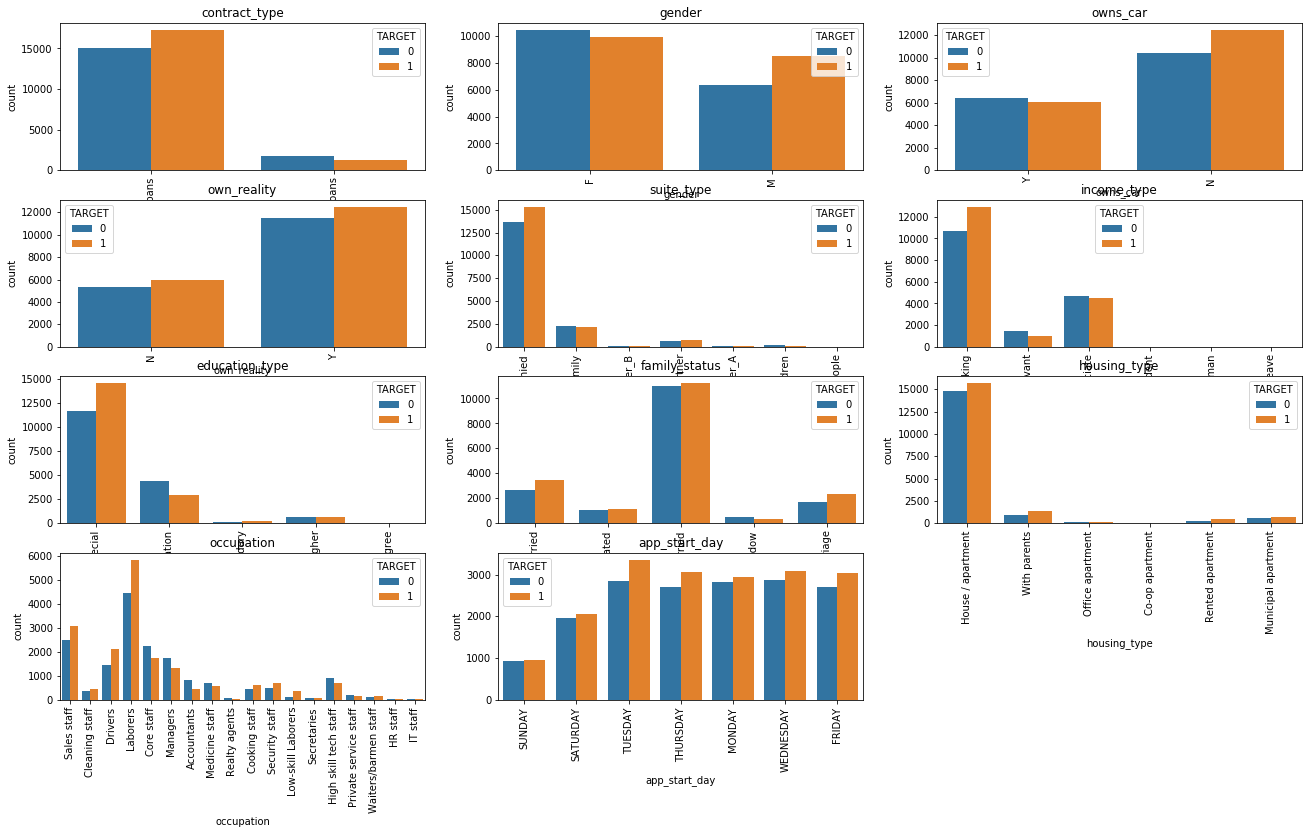

In [42]:
counter = 1
for i in loan_01_02_cat.columns[0:-2]:
    plt.subplot(4,3,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="TARGET",x=loan_01_02_cat[i].dropna(),data=loan_01_02_cat) #df[i].dropna()
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=.4, right=3, top=2.75)
    plt.title(i)
    counter += 1

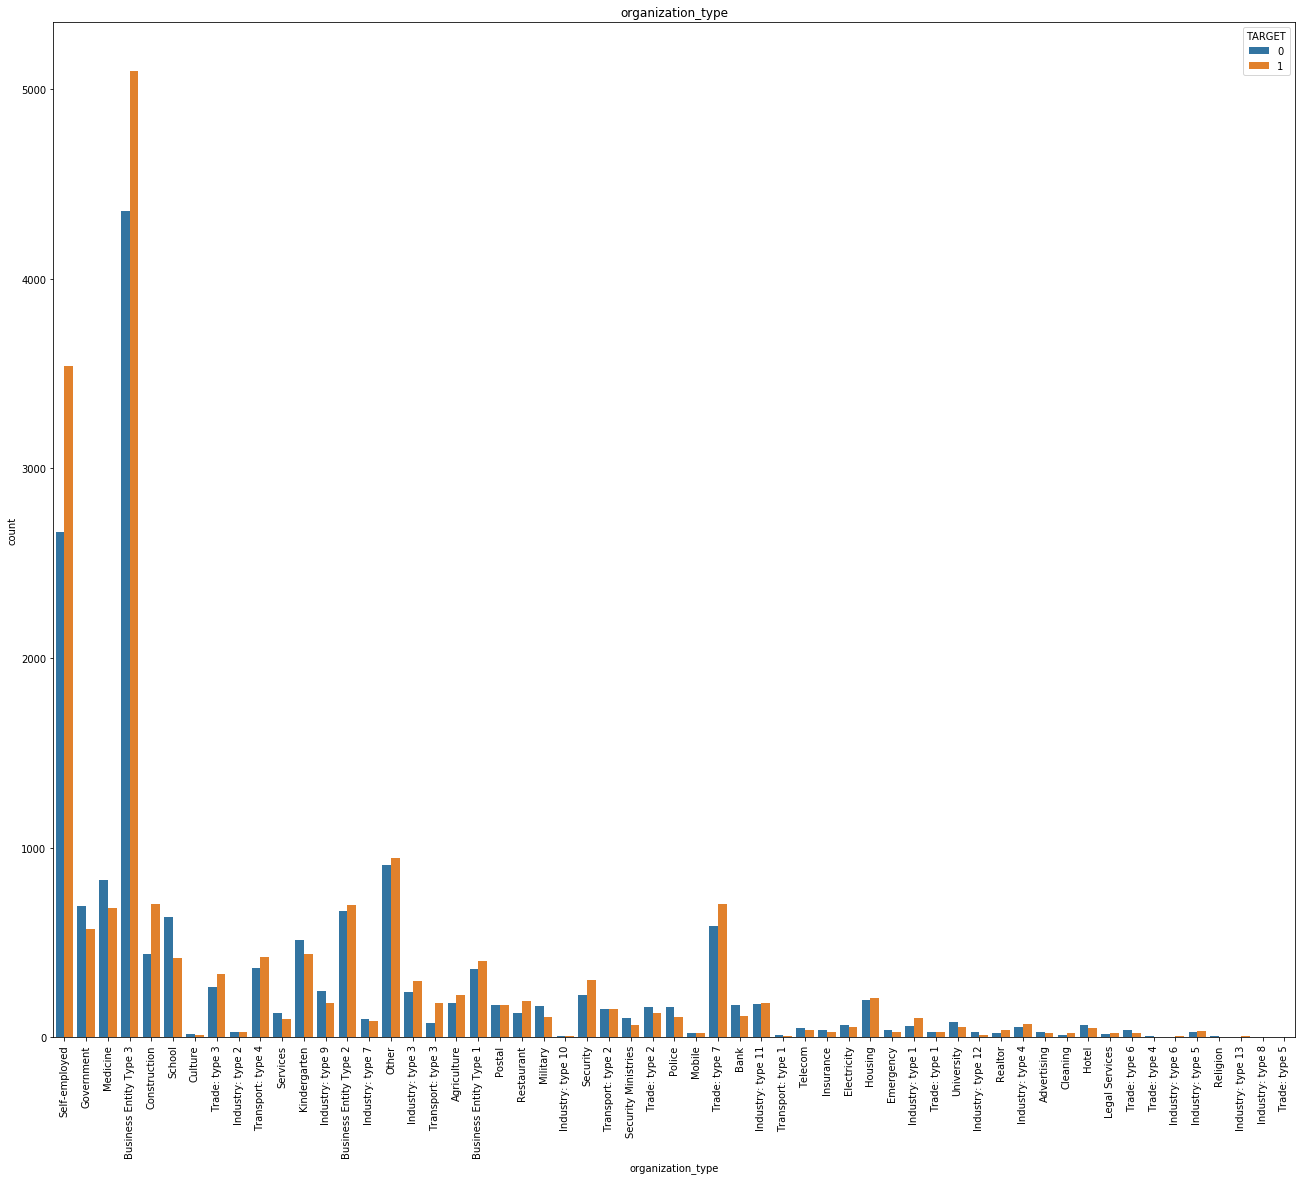

In [43]:
counter = 1
for i in loan_01_02_cat.columns[-2:-1]:
    plt.subplot(1,1,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    sns.countplot(hue="TARGET",x=loan_01_02_cat[i].dropna(),data=loan_01_02_cat) #df[i].dropna()
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=.4, right=3, top=2.75)
    plt.title(i)
    counter += 1

## Categorical data analysis
### Assumptions 
1. The data represents personal loans offered by financial institutions 
2. Each applicant provides the required data to get the loan
3. The fianncial instituting has put in good efforts to report quality data

After studying the categorical data displayed in the bar graphs the following can be proposed

1. In the category of gender even though men tend to get fewer loans compared to women, they tend to default more than women. This might be just pointing out that a. while men have a better economic conditions they are also the over estimating their finances.

2.People that do not own a car get more loans and within those that don't have a car tend to default more often. 
This might indicate that the loan is intended to purchase a car. (Assuming do not have a car == don't own a car)

3.People who "reality" tend to default more often than not, again indicating that they might be stretching their finances too tight.

4.I am not sure if "Unaccompanied" == unmarried, but if that is the case this bank need ask them to be married first, 'cuz they have the highest number of defaults. :), jokes aside this might mean that people that are single (if that is what unaccompanied means) lack the family supportt with finances to payback.

5.this is a biggie, people working in unorganized secotrs tend to be the next biggest defaulters and this is evident from both "Occupation_Type" and the "organization_Type"

# Numerical Data Analysis
we again started by inspecting the "columns_Description" file. This time we found that the columns with numerical values had both float and interger values that we decided to merge. There were columns that had 0,1 for No and Yes which are clsasified as integers but can be interpreted as objects. 

1.Instead of treating them as objects we took advantage of them being intergers and found the "sum" of the the columns and treated that number as the "level" of proof for example in columns that had information about physical address or for that matter the columns that had cell phone, phone, office phone etc.

2. columns that had "Days" in them were turned in to years by dividing it by -365. The removal of negative sign assisted in interpreting the age of the client for example.

3. we assumed that the negative sign indicated number of days before the appication and the positive sign indicated the number of days after. So any number that turned out to be negative after dividing by -365 was dropped . This makes sense as wee are dealing with numbers that represent positive real numbers such as age, years of employment etc.

In [44]:
Non_Defaulters.shape

(282250, 28)

## Working on Numerical columns now. Creating a DF for which has both Integer and Float Columns

In [45]:
loan_0_float = loan_0.loc[:,loan_0.dtypes==np.float64]
loan_0_int   = loan_0.loc[:,loan_0.dtypes==np.int64]

loan_1_float = Defaulters.loc[:,Defaulters.dtypes == np.float64]
loan_1_int   = Defaulters.loc[:,Defaulters.dtypes == np.int64]



#### Merging dataframes with float and interger for non-defaulters

In [46]:
loan_0_numerical=pd.concat([loan_0_int,loan_0_float],axis=1)
loan_0_numerical.shape

(24803, 16)

In [47]:
loan_0_numerical = pd.concat([loan_0_int,loan_0_float],axis=1)
loan_1_numerical = pd.concat([loan_1_int,loan_1_float],axis=1)
loan_0_numerical.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'Document', 'Applicant_Contact', 'Address_Missmatch',
       'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'loan_cr_Average',
       'Social_Circle_PD', 'Debt_Income_Ratio', 'Income_PerMonth', 'EMI'],
      dtype='object')

In [48]:
loan_0_numerical.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,Document,Applicant_Contact,Address_Missmatch,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Social_Circle_PD,Debt_Income_Ratio,Income_PerMonth,EMI
84940,198543,0,0,-9632,-364,-2276,1,4,8,1.0,-742.0,0.507738,8.0,0.197037,6750.0,1330.0
184759,314162,0,0,-11367,-1030,-3601,1,4,8,1.0,-161.0,0.543971,22.0,0.139911,5625.0,787.0
230750,367274,0,0,-10184,-581,-2850,1,4,8,2.0,-744.0,0.639481,2.0,0.134019,13125.0,1759.0
109528,227028,0,0,-20615,-2218,-3782,1,5,10,2.0,-229.0,0.542314,0.0,0.073917,12000.0,887.0
274986,418718,0,0,-19162,-1999,-2713,1,5,10,2.0,-351.0,0.565650,0.0,0.238739,20625.0,4924.0


In [49]:
for x in loan_0_numerical.columns:
    if 'DAYS' in x.split('_'):
        #print(x)
        loan_0_numerical[x] = round(loan_0_numerical[x]/-365,1)

for x in loan_1_numerical.columns:
    if 'DAYS' in x.split('_'):
        #print(x)
        loan_1_numerical[x] = round(loan_1_numerical[x]/-365,1)
        
loan_0_numerical.shape

(24803, 16)

In [50]:
loan_0_numerical.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,Document,Applicant_Contact,Address_Missmatch,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Social_Circle_PD,Debt_Income_Ratio,Income_PerMonth,EMI
84940,198543,0,0,26.4,1.0,6.2,1,4,8,1.0,2.0,0.507738,8.0,0.197037,6750.0,1330.0
184759,314162,0,0,31.1,2.8,9.9,1,4,8,1.0,0.4,0.543971,22.0,0.139911,5625.0,787.0
230750,367274,0,0,27.9,1.6,7.8,1,4,8,2.0,2.0,0.639481,2.0,0.134019,13125.0,1759.0
109528,227028,0,0,56.5,6.1,10.4,1,5,10,2.0,0.6,0.542314,0.0,0.073917,12000.0,887.0
274986,418718,0,0,52.5,5.5,7.4,1,5,10,2.0,1.0,0.565650,0.0,0.238739,20625.0,4924.0


In [51]:
loan_0_numerical.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'Document', 'Applicant_Contact', 'Address_Missmatch',
       'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE', 'loan_cr_Average',
       'Social_Circle_PD', 'Debt_Income_Ratio', 'Income_PerMonth', 'EMI'],
      dtype='object')

In [52]:
loan_0_numerical=loan_0_numerical.rename(columns={'DAYS_BIRTH':'Age_years', 'DAYS_EMPLOYED':'Years_Employed',
       'DAYS_ID_PUBLISH':'Years_Id_publish','DAYS_REGISTRATION':'Years_Registration'})

loan_1_numerical=loan_1_numerical.rename(columns={'DAYS_BIRTH':'Age_years', 'DAYS_EMPLOYED':'Years_Employed',
       'DAYS_ID_PUBLISH':'Years_Id_publish','DAYS_REGISTRATION':'Years_Registration'})

loan_0_numerical.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,Age_years,Years_Employed,Years_Id_publish,Document,Applicant_Contact,Address_Missmatch,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Social_Circle_PD,Debt_Income_Ratio,Income_PerMonth,EMI
84940,198543,0,0,26.4,1.0,6.2,1,4,8,1.0,2.0,0.507738,8.0,0.197037,6750.0,1330.0
184759,314162,0,0,31.1,2.8,9.9,1,4,8,1.0,0.4,0.543971,22.0,0.139911,5625.0,787.0
230750,367274,0,0,27.9,1.6,7.8,1,4,8,2.0,2.0,0.639481,2.0,0.134019,13125.0,1759.0
109528,227028,0,0,56.5,6.1,10.4,1,5,10,2.0,0.6,0.542314,0.0,0.073917,12000.0,887.0
274986,418718,0,0,52.5,5.5,7.4,1,5,10,2.0,1.0,0.565650,0.0,0.238739,20625.0,4924.0


In [53]:
loan_0_numerical.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'Age_years', 'Years_Employed',
       'Years_Id_publish', 'Document', 'Applicant_Contact',
       'Address_Missmatch', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE',
       'loan_cr_Average', 'Social_Circle_PD', 'Debt_Income_Ratio',
       'Income_PerMonth', 'EMI'],
      dtype='object')

### Creating df without outliers


In [54]:
for i in loan_0_numerical.columns:
    print('min of', i , 'is',loan_0_numerical[i].describe()[3], 'max of',i,'is',loan_0_numerical[i].describe()[7] )

min of SK_ID_CURR is 100020.0 max of SK_ID_CURR is 456239.0
min of TARGET is 0.0 max of TARGET is 0.0
min of CNT_CHILDREN is 0.0 max of CNT_CHILDREN is 8.0
min of Age_years is 21.1 max of Age_years is 69.0
min of Years_Employed is -1000.7 max of Years_Employed is 48.2
min of Years_Id_publish is 0.0 max of Years_Id_publish is 17.0
min of Document is 0.0 max of Document is 1.0
min of Applicant_Contact is 1.0 max of Applicant_Contact is 6.0
min of Address_Missmatch is 2.0 max of Address_Missmatch is 12.0
min of CNT_FAM_MEMBERS is 1.0 max of CNT_FAM_MEMBERS is 10.0
min of DAYS_LAST_PHONE_CHANGE is -0.0 max of DAYS_LAST_PHONE_CHANGE is 11.8
min of loan_cr_Average is 0.00036481651740081215 max of loan_cr_Average is 0.8636778862831115
min of Social_Circle_PD is 0.0 max of Social_Circle_PD is 54.0
min of Debt_Income_Ratio is 0.0103 max of Debt_Income_Ratio is 1.5704
min of Income_PerMonth is 2137.0 max of Income_PerMonth is 187500.0
min of EMI is 165.0 max of EMI is 18750.0


In [55]:
loan_0_numerical['Years_Employed'].describe()

count    24803.000000
mean      -176.469818
std        388.564386
min      -1000.700000
25%          0.800000
50%          3.400000
75%          7.700000
max         48.200000
Name: Years_Employed, dtype: float64

In [56]:
loan_0_numerical.shape

(24803, 16)

#### Checking boxplot for outliers before removing outliers from the columns   :  Non-Defaulters Numerical Columns

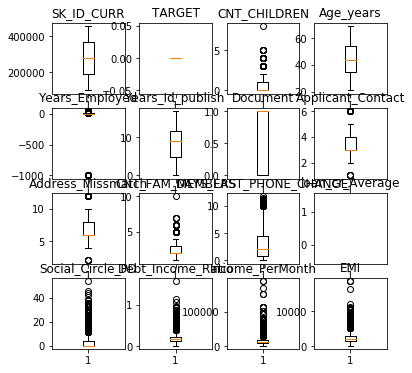

In [57]:
counter =1
for i in loan_0_numerical.columns:
    plt.subplot(4,4,counter)
    plt.rcParams["figure.figsize"] = [12,17]
    plt.boxplot(loan_0_numerical[i])
    plt.title(i)
    counter = counter + 1

In [58]:
loan_1_numerical.shape

(24803, 16)

#### Checking boxplot for outliers before removing outliers from the columns   :  Defaulters Numerical Columns

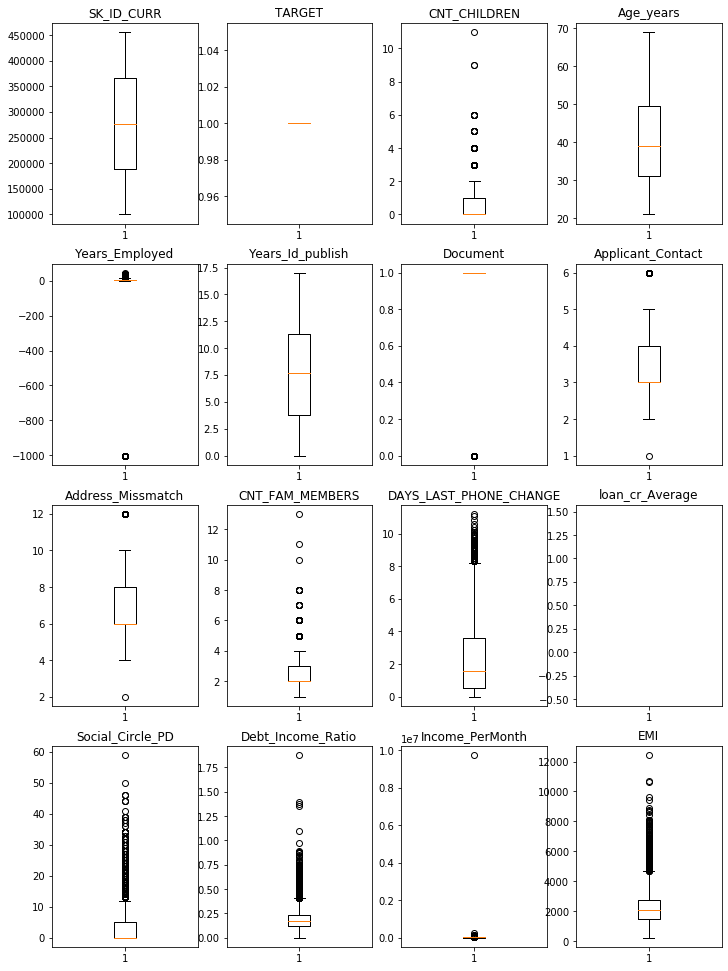

In [59]:
counter =1
for i in loan_1_numerical.columns:
    plt.subplot(4,4,counter)
    plt.rcParams["figure.figsize"] = [12,17]
    plt.boxplot(loan_1_numerical[i])
    plt.title(i)
    counter = counter + 1

In [60]:
loan_0_numerical.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'Age_years', 'Years_Employed',
       'Years_Id_publish', 'Document', 'Applicant_Contact',
       'Address_Missmatch', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE',
       'loan_cr_Average', 'Social_Circle_PD', 'Debt_Income_Ratio',
       'Income_PerMonth', 'EMI'],
      dtype='object')

### Removing outliers for Non-Defaulters Numerical Columns

In [61]:
lis=['CNT_CHILDREN','Years_Employed','Applicant_Contact','Address_Missmatch','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE','Debt_Income_Ratio',
'Income_PerMonth','Social_Circle_PD','EMI']

for i in lis:
    q1 = loan_0_numerical[i].quantile(0.25)
    q3 = loan_0_numerical[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    l = q1-1.5*iqr
    h = q3+1.5*iqr
    loan_0_numerical = loan_0_numerical.loc[(loan_0_numerical[i] > l) & (loan_0_numerical[i] < h)]
    

In [62]:
loan_0_numerical['Debt_Income_Ratio'].describe()

count    15377.000000
mean         0.167936
std          0.075331
min          0.016041
25%          0.111526
50%          0.156267
75%          0.215127
max          0.389935
Name: Debt_Income_Ratio, dtype: float64

### Plotting boxplot for Non-Defaulters Numerical Columns

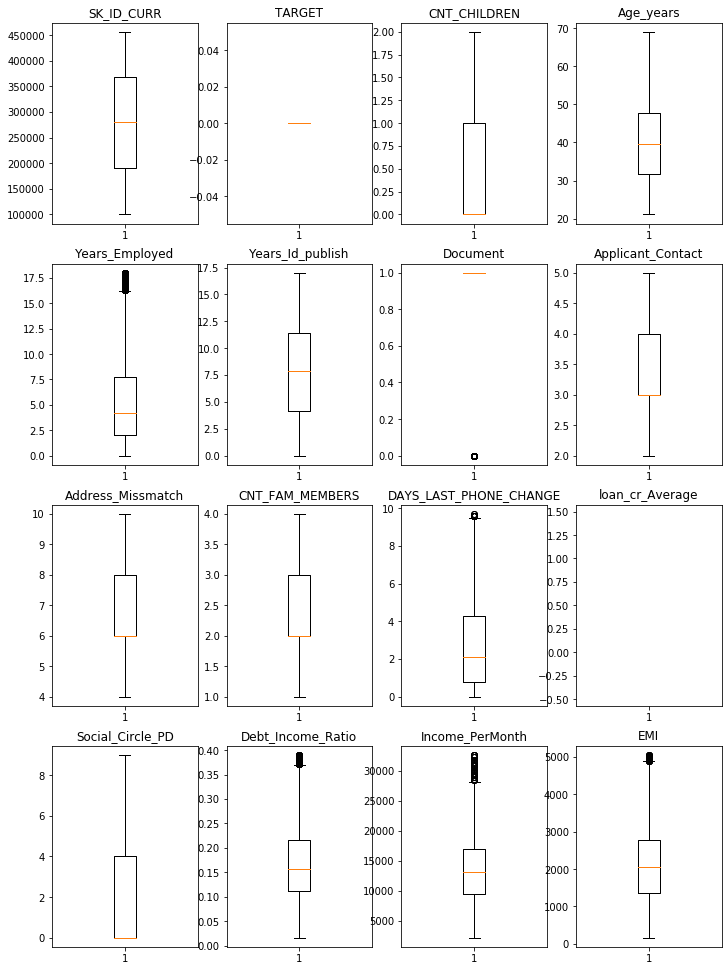

In [63]:
counter =1
for i in loan_0_numerical.columns:
    plt.subplot(4,4,counter)
    plt.rcParams["figure.figsize"] = [12,17]
    plt.boxplot(loan_0_numerical[i])
    plt.title(i)
    counter = counter + 1

### Removing outliers for Defaulters Numerical Columns and Plotting boxplot for Defaulters Numerical Columns

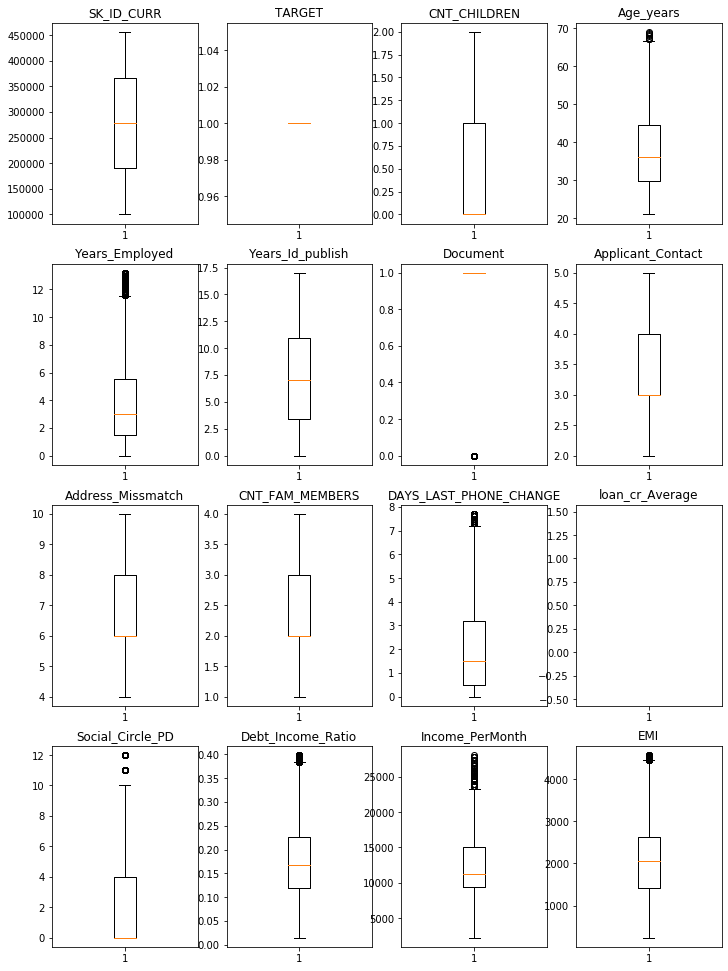

In [64]:
lis=['CNT_CHILDREN','Years_Employed','Applicant_Contact','Address_Missmatch','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE','Debt_Income_Ratio',
'Income_PerMonth','Social_Circle_PD','EMI']

for i in lis:
    q1 = loan_1_numerical[i].quantile(0.25)
    q3 = loan_1_numerical[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    l = q1-1.5*iqr
    h = q3+1.5*iqr
    loan_1_numerical = loan_1_numerical.loc[(loan_1_numerical[i] > l) & (loan_1_numerical[i] < h)]


counter =1
for i in loan_1_numerical.columns:
    plt.subplot(4,4,counter)
    plt.rcParams["figure.figsize"] = [12,17]
    plt.boxplot(loan_1_numerical[i])
    plt.title(i)
    counter = counter + 1

In [65]:
#loan_1_numerical['Social_Circle_PD'].describe()

In [66]:
#loan_0_numerical['Years_Employed'].describe()

In [67]:
#loan_1_numerical.columns

## Plotting Binned Histogram for Defaulters Numeric Continuos Columns

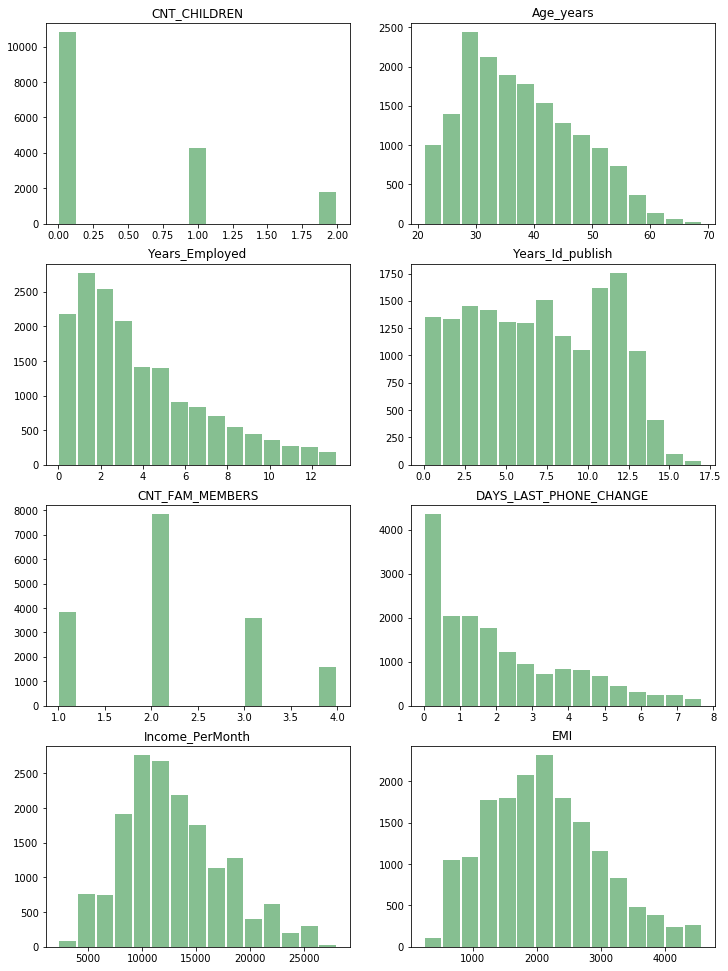

In [68]:
lis1=['CNT_CHILDREN','Age_years','Years_Employed','Years_Id_publish','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE','Income_PerMonth','EMI']
counter =1
for i in lis1:
    plt.subplot(4,2,counter)
    #plt.rcParams[i] = [25,30]
    plt.hist(loan_1_numerical[i],bins=15, color='#86bf91', zorder=2, rwidth=0.9)
    plt.title(i)
    counter = counter + 1

In [69]:
loan_0_numerical['Income_PerMonth'].describe()

count    15377.000000
mean     13806.746895
std       5711.613886
min       2137.000000
25%       9375.000000
50%      13125.000000
75%      16875.000000
max      32625.000000
Name: Income_PerMonth, dtype: float64

## Plotting Binned Histogram for Non-Defaulters Numeric Continuos Columns

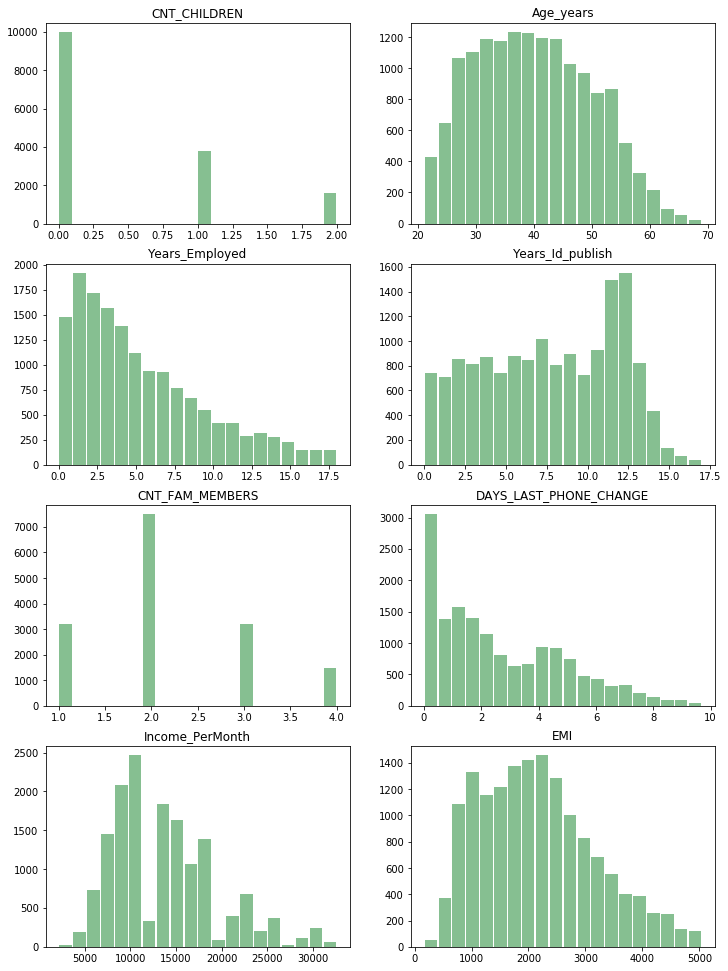

In [70]:
lis1=['CNT_CHILDREN','Age_years','Years_Employed','Years_Id_publish','CNT_FAM_MEMBERS','DAYS_LAST_PHONE_CHANGE','Income_PerMonth','EMI']
counter =1
for i in lis1:
    plt.subplot(4,2,counter)
    #plt.rcParams[i] = [25,30]
    plt.hist(loan_0_numerical[i],bins=20, color='#86bf91', zorder=2, rwidth=0.9)
    plt.title(i)
    counter = counter + 1

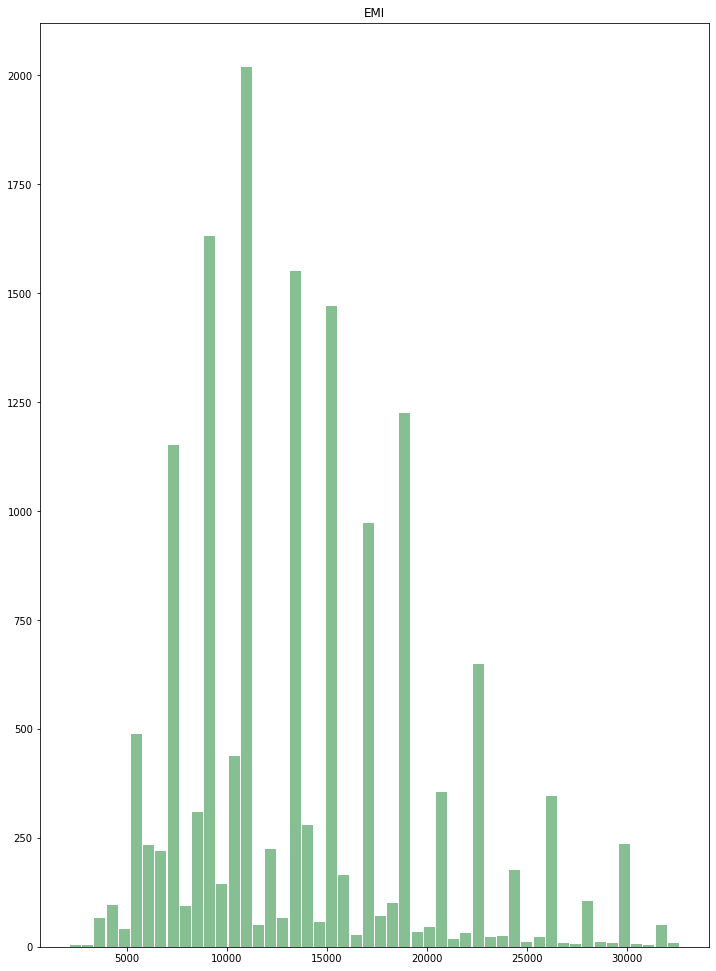

In [71]:
plt.hist(loan_0_numerical['Income_PerMonth'],bins=50, color='#86bf91', zorder=2, rwidth=0.9)
plt.title(i)
counter = counter + 1

In [72]:
loan_0_numerical.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'Age_years', 'Years_Employed',
       'Years_Id_publish', 'Document', 'Applicant_Contact',
       'Address_Missmatch', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE',
       'loan_cr_Average', 'Social_Circle_PD', 'Debt_Income_Ratio',
       'Income_PerMonth', 'EMI'],
      dtype='object')

In [73]:
loan_0_numerical_conti=loan_0_numerical['Income_PerMonth']

In [74]:
loan_0_numerical

,SK_ID_CURR,TARGET,CNT_CHILDREN,Age_years,Years_Employed,Years_Id_publish,Document,Applicant_Contact,Address_Missmatch,CNT_FAM_MEMBERS,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Social_Circle_PD,Debt_Income_Ratio,Income_PerMonth,EMI
84940,198543,0,0,26.4,1.0,6.2,1,4,8,1.0,2.0,0.507738,8.0,0.197037,6750.0,1330.0
230750,367274,0,0,27.9,1.6,7.8,1,4,8,2.0,2.0,0.639481,2.0,0.134019,13125.0,1759.0
109528,227028,0,0,56.5,6.1,10.4,1,5,10,2.0,0.6,0.542314,0.0,0.073917,12000.0,887.0
274986,418718,0,0,52.5,5.5,7.4,1,5,10,2.0,1.0,0.565650,0.0,0.238739,20625.0,4924.0
176513,304543,0,2,43.0,10.7,6.4,1,4,8,3.0,7.2,0.603372,0.0,0.256089,11250.0,2881.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239280,377122,0,2,33.4,5.7,4.6,1,3,6,4.0,1.5,0.423011,8.0,0.143467,13125.0,1883.0
57290,166401,0,0,23.2,2.0,3.1,1,4,8,1.0,2.9,0.204575,6.0,0.186667,11250.0,2100.0
248217,387184,0,1,44.3,10.9,11.8,0,3,6,3.0,4.3,0.756412,6.0,0.159600,15000.0,2394.0
387,100449,0,0,46.1,15.2,1.0,1,3,6,1.0,2.3,0.549267,0.0,0.175695,13125.0,2306.0


In [75]:
loan_0_numerical_conti = loan_0_numerical[['Age_years','Years_Employed','Years_Id_publish','DAYS_LAST_PHONE_CHANGE','loan_cr_Average', 'Debt_Income_Ratio', 'Income_PerMonth', 'EMI']]
loan_0_numerical_dis = loan_0_numerical[['CNT_CHILDREN','Document','Applicant_Contact','Address_Missmatch','CNT_FAM_MEMBERS','Social_Circle_PD']]

loan_1_numerical_conti = loan_1_numerical[['Age_years','Years_Employed','Years_Id_publish','DAYS_LAST_PHONE_CHANGE','loan_cr_Average', 'Debt_Income_Ratio', 'Income_PerMonth', 'EMI']]
loan_1_numerical_dis = loan_1_numerical[['CNT_CHILDREN','Document','Applicant_Contact','Address_Missmatch','CNT_FAM_MEMBERS','Social_Circle_PD']]


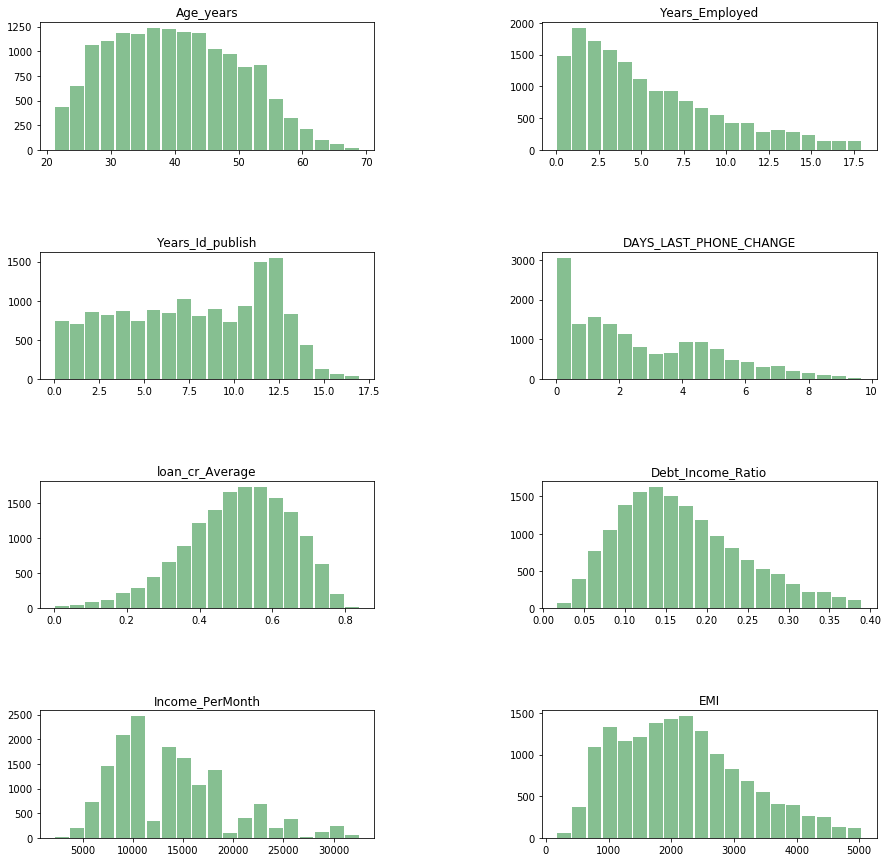

In [76]:
c = 1
plt.figure(figsize = (15,15))
for i in loan_0_numerical_conti:
    plt.subplot(4,2,c)
    plt.title(i)
    plt.hist(loan_0_numerical_conti[i],bins=20, color='#86bf91', zorder=2, rwidth=0.9)
    c +=1
plt.subplots_adjust(hspace = 0.8,wspace = 0.5)


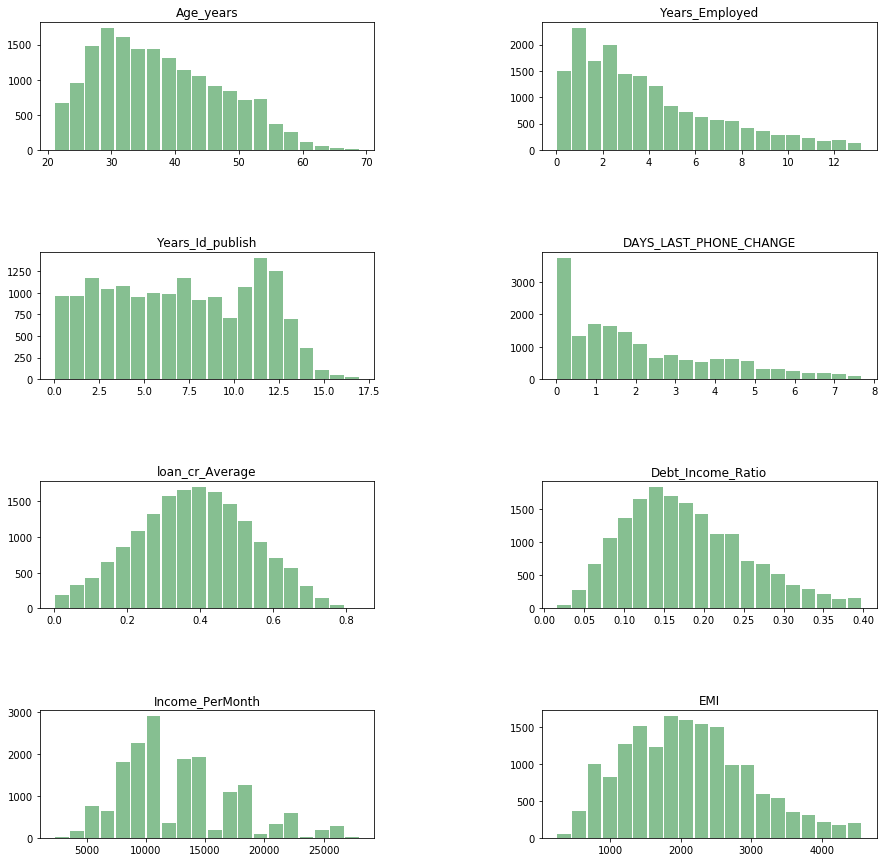

In [77]:
c = 1
plt.figure(figsize = (15,15))
for i in loan_1_numerical_conti:
    plt.subplot(4,2,c)
    plt.title(i)
    plt.hist(loan_1_numerical_conti[i],bins=20, color='#86bf91', zorder=2, rwidth=0.9)
    c +=1
plt.subplots_adjust(hspace = 0.8,wspace = 0.5)

In [78]:
loan_0_numerical_dis["TARGET"]=loan["TARGET"]
loan_1_numerical_dis["TARGET"]=loan["TARGET"]

In [79]:
loan_0_1_numerical_dis=pd.concat([loan_0_numerical_dis,loan_1_numerical_dis])
loan_0_1_numerical_dis["TARGET"]=loan["TARGET"]

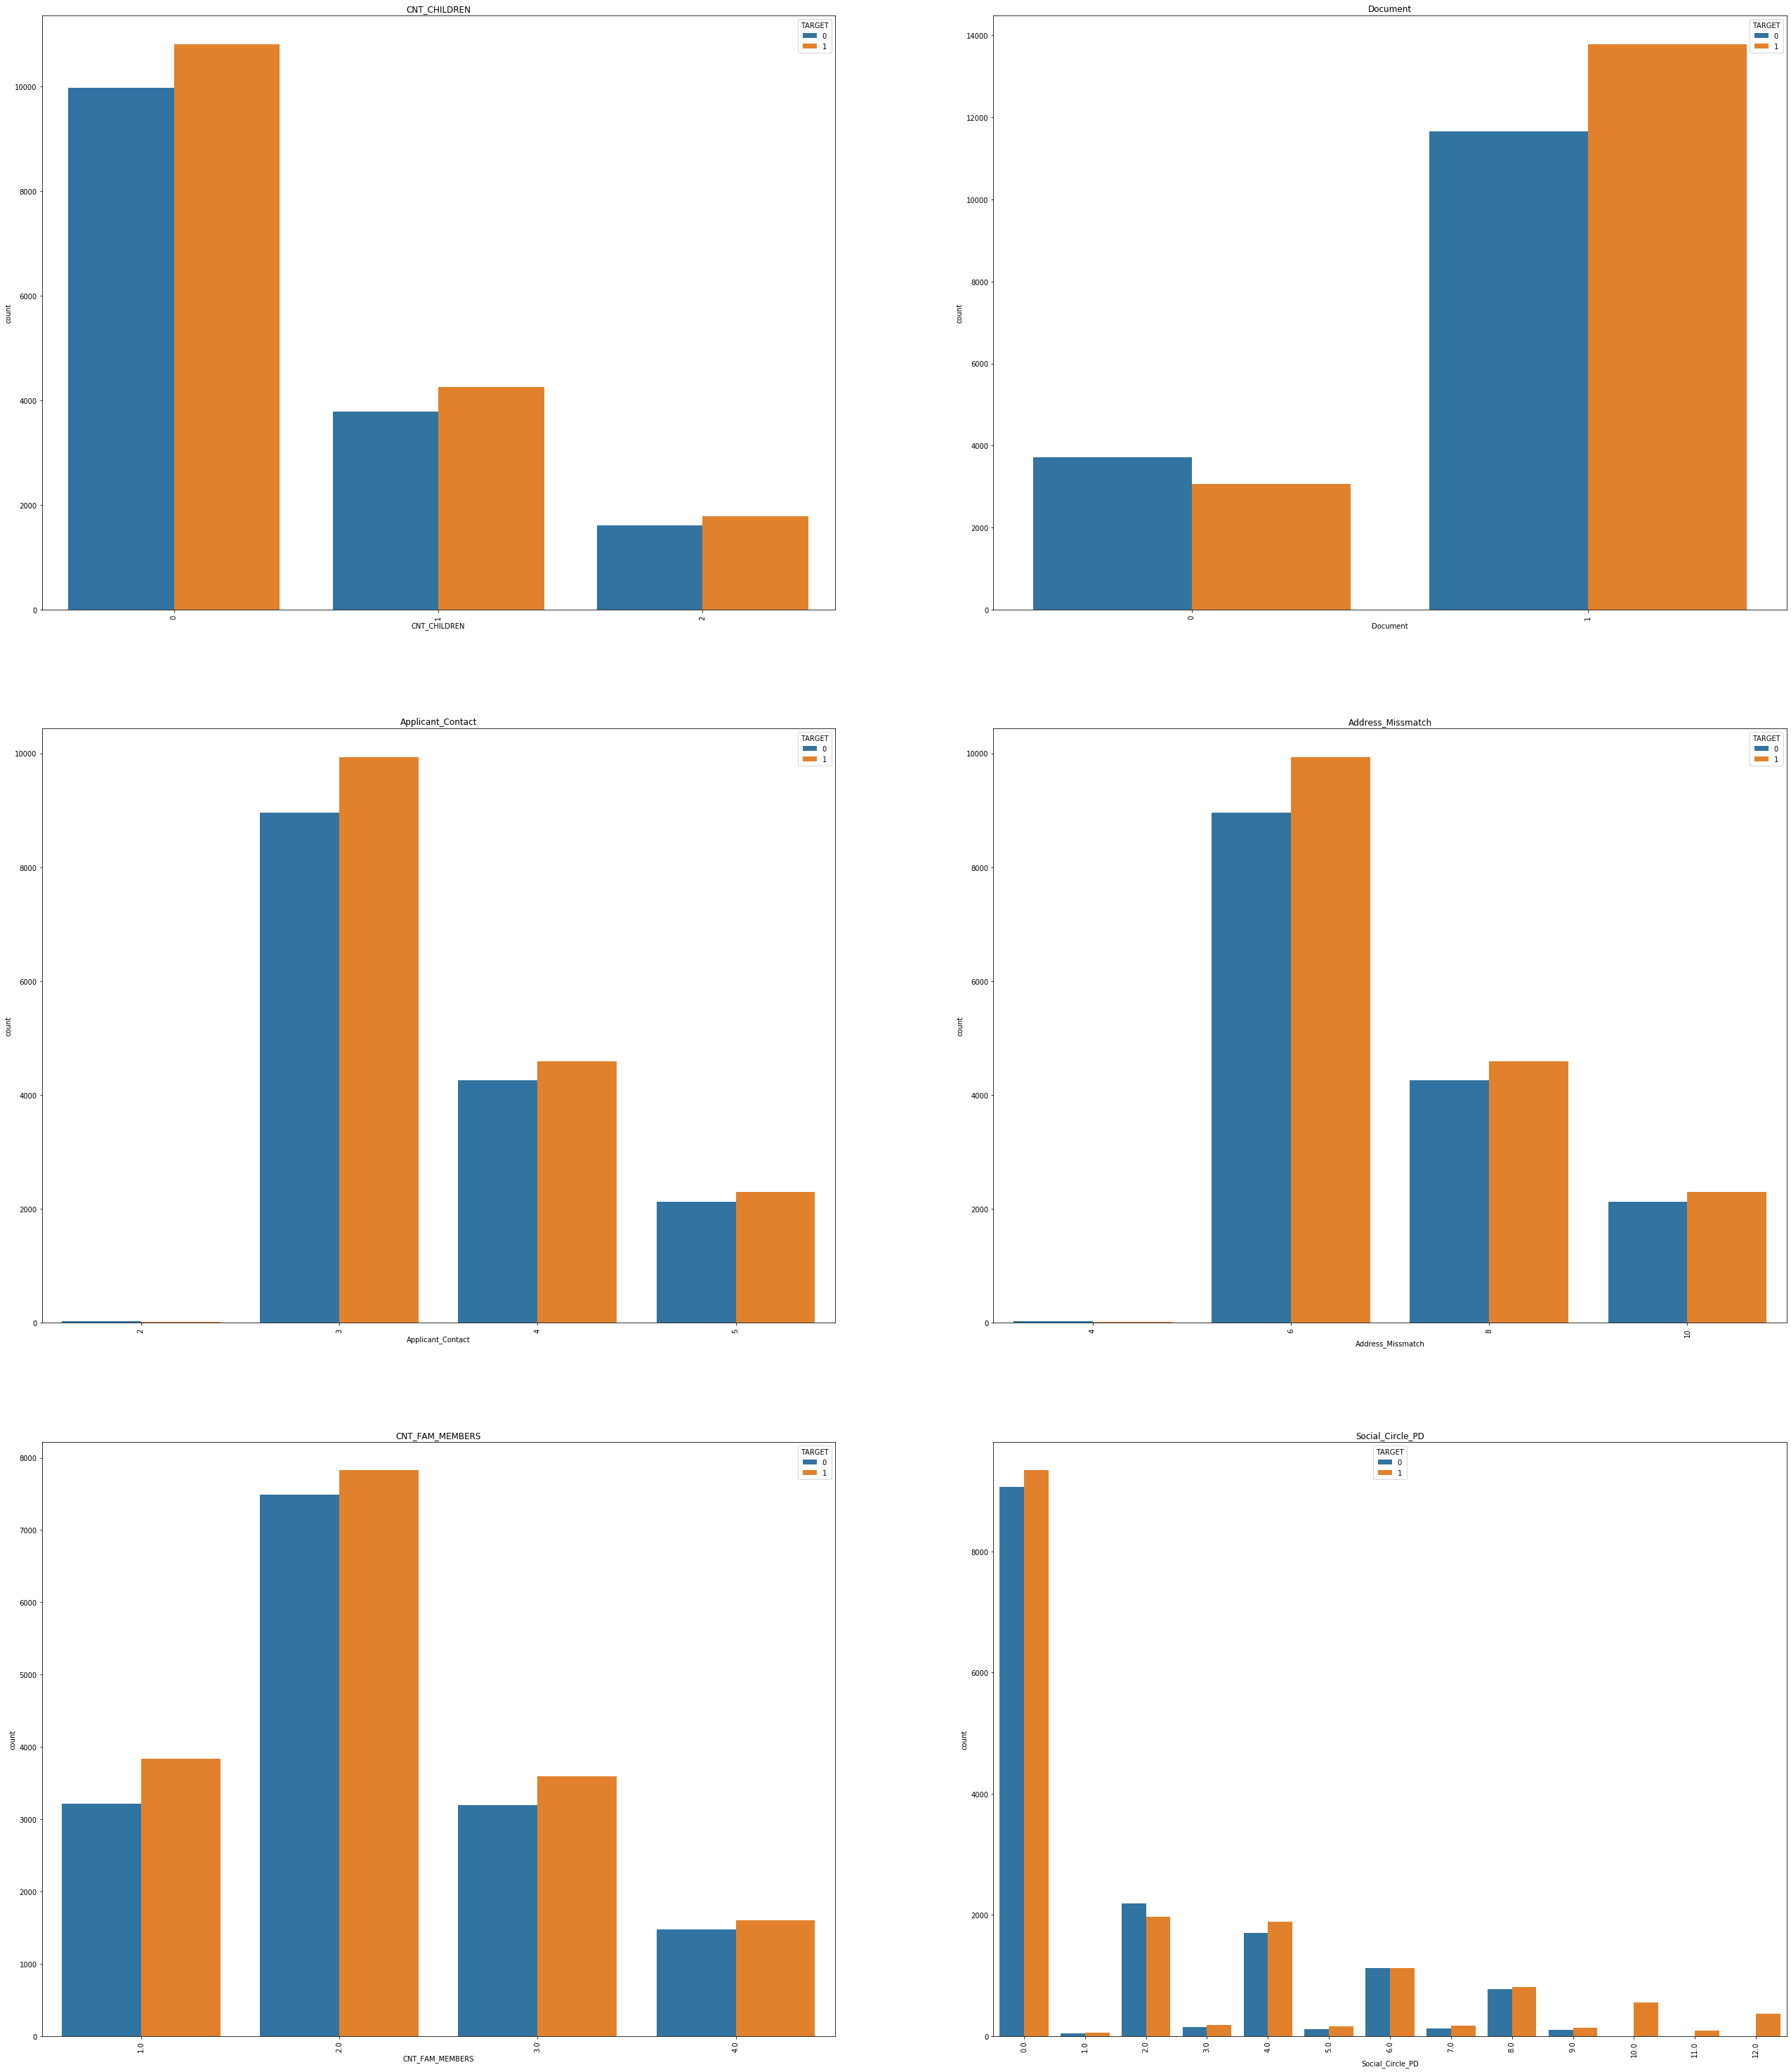

In [80]:
counter = 1
for i in loan_0_1_numerical_dis.columns[0:-1]:
    plt.subplot(3,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    sns.countplot(hue="TARGET",x=loan_0_1_numerical_dis[i].dropna(),data=loan_0_1_numerical_dis) #df[i].dropna()
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=.4, right=3, top=2.75)
    plt.title(i)
    counter += 1

###  Heatmaps

In [81]:
loan_0_numerical_conti.head(5)


,Age_years,Years_Employed,Years_Id_publish,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Debt_Income_Ratio,Income_PerMonth,EMI
84940,26.4,1.0,6.2,2.0,0.507738,0.197037,6750.0,1330.0
230750,27.9,1.6,7.8,2.0,0.639481,0.134019,13125.0,1759.0
109528,56.5,6.1,10.4,0.6,0.542314,0.073917,12000.0,887.0
274986,52.5,5.5,7.4,1.0,0.565650,0.238739,20625.0,4924.0
176513,43.0,10.7,6.4,7.2,0.603372,0.256089,11250.0,2881.0


,Age_years,Years_Employed,Years_Id_publish,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Debt_Income_Ratio,Income_PerMonth,EMI
Age_years,1.000000,0.254847,0.112928,0.148126,0.315785,0.049329,0.064203,0.099004
Years_Employed,0.254847,1.000000,0.114297,0.161214,0.158913,0.008865,0.072316,0.065819
Years_Id_publish,0.112928,0.114297,1.000000,0.106502,0.128328,-0.013285,0.045286,0.019699
DAYS_LAST_PHONE_CHANGE,0.148126,0.161214,0.106502,1.000000,0.211452,0.018670,0.070330,0.074566
loan_cr_Average,0.315785,0.158913,0.128328,0.211452,1.000000,0.034450,0.091600,0.114810
Debt_Income_Ratio,0.049329,0.008865,-0.013285,0.018670,0.034450,1.000000,-0.376996,0.575004
Income_PerMonth,0.064203,0.072316,0.045286,0.070330,0.091600,-0.376996,1.000000,0.460676
EMI,0.099004,0.065819,0.019699,0.074566,0.114810,0.575004,0.460676,1.000000


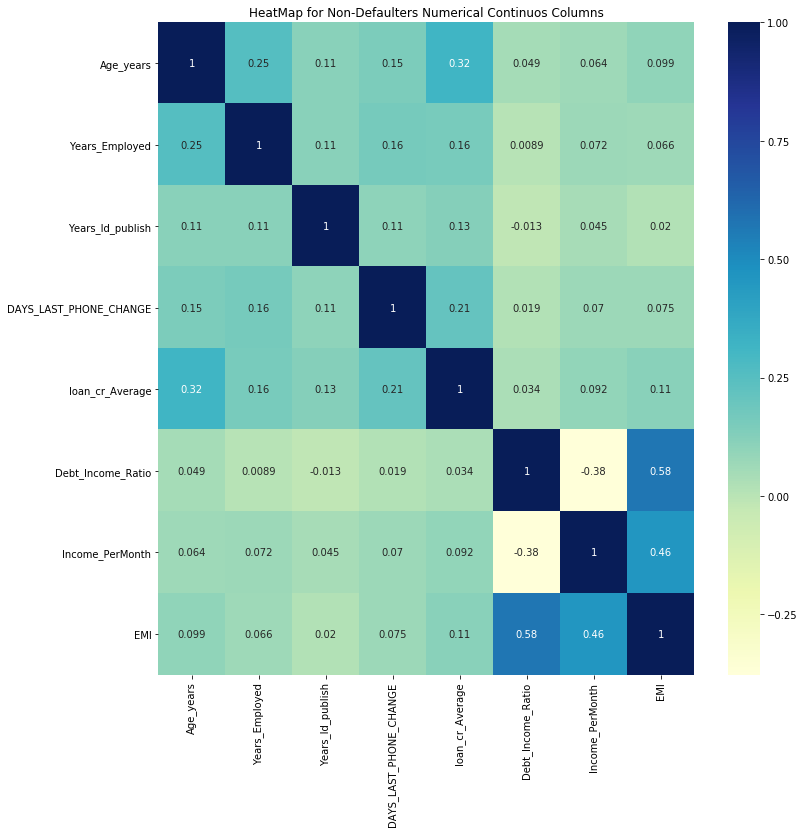

In [82]:
loan_0_numerical_conti_corr = loan_0_numerical_conti.corr()
plt.figure(figsize=(12,12))
ax=sns.heatmap(loan_0_numerical_conti_corr,annot=True,cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('HeatMap for Non-Defaulters Numerical Continuos Columns')
loan_0_numerical_conti.corr()

,Age_years,Years_Employed,Years_Id_publish,DAYS_LAST_PHONE_CHANGE,loan_cr_Average,Debt_Income_Ratio,Income_PerMonth,EMI
Age_years,1.000000,0.194818,0.151780,0.127403,0.254451,0.014171,0.099787,0.088131
Years_Employed,0.194818,1.000000,0.109729,0.179474,0.130160,0.015914,0.066634,0.068763
Years_Id_publish,0.151780,0.109729,1.000000,0.130271,0.111217,0.002794,0.048918,0.042330
DAYS_LAST_PHONE_CHANGE,0.127403,0.179474,0.130271,1.000000,0.195287,0.002537,0.073172,0.067277
loan_cr_Average,0.254451,0.130160,0.111217,0.195287,1.000000,0.018007,0.096569,0.106539
Debt_Income_Ratio,0.014171,0.015914,0.002794,0.002537,0.018007,1.000000,-0.428573,0.572401
Income_PerMonth,0.099787,0.066634,0.048918,0.073172,0.096569,-0.428573,1.000000,0.417762
EMI,0.088131,0.068763,0.042330,0.067277,0.106539,0.572401,0.417762,1.000000


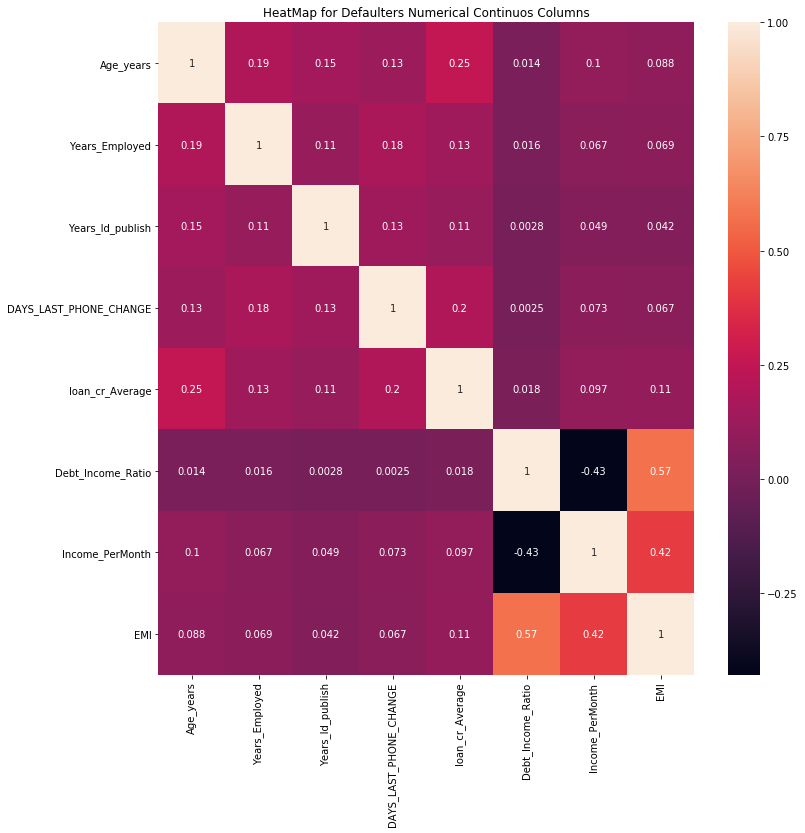

In [83]:
loan_1_numerical_conti_corr = loan_1_numerical_conti.corr()
plt.figure(figsize=(12,12))
ax=sns.heatmap(loan_1_numerical_conti_corr,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('HeatMap for Defaulters Numerical Continuos Columns')
loan_1_numerical_conti.corr()

# Problem statement II

In [84]:
prev_loan=pd.read_csv('prev_app.csv')

In [85]:
prev_loan.shape

(1670214, 37)

### Merge on SK ID with Defaulters and Non_Defaulters dataframes from Previous Part

In [86]:
pd.options.display.max_columns = None
ds_comb_with_non_def = pd.merge(prev_loan,Non_Defaulters,on='SK_ID_CURR',how = 'inner')
ds_comb_with_def = pd.merge(prev_loan,Defaulters,on='SK_ID_CURR',how = 'inner')
ds_comb_with_non_def.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_x,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START_x,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_x,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET,NAME_CONTRACT_TYPE_y,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE_y,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,WEEKDAY_APPR_PROCESS_START_y,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,Document,loan_cr_Average,Applicant_Contact,Social_Circle_PD,Address_Missmatch,Debt_Income_Ratio,Income_PerMonth,EMI
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0,Cash loans,F,N,Y,1,Unaccompanied,State servant,Incomplete higher,Married,House / apartment,-14443,-7392,-4120,NaN,3.0,TUESDAY,Military,-548.0,0,0.683797,4,6.0,8,0.114667,18750.0,2150.0
1,1696966,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,Y,1,0.101325,NaN,NaN,XAP,Refused,-472,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,0,Cash loans,F,N,Y,1,Unaccompanied,State servant,Incomplete higher,Married,House / apartment,-14443,-7392,-4120,NaN,3.0,TUESDAY,Military,-548.0,0,0.683797,4,6.0,8,0.114667,18750.0,2150.0
2,2154916,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,Y,1,0.000000,NaN,NaN,XAP,Approved,-548,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,0,Cash loans,F,N,Y,1,Unaccompanied,State servant,Incomplete higher,Married,House / apartment,-14443,-7392,-4120,NaN,3.0,TUESDAY,Military,-548.0,0,0.683797,4,6.0,8,0.114667,18750.0,2150.0
3,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0,Revolving loans,F,N,N,0,Family,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-21335,-1255,-4263,Private service staff,2.0,SUNDAY,Self-employed,-517.0,0,0.663524,3,0.0,6,0.074933,7500.0,562.0
4,1536272,108129,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-515,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,0,Revolving loans,F,N,N,0,Family,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-21335,-1255,-4263,Private service staff,2.0,SUNDAY,Self-employed,-517.0,0,0.663524,3,0.0,6,0.074933,7500.0,562.0


### Replacing XNA and XAP with Nan, and removing Rows and Columns with more than 40% nulls respectively

In [87]:
ds_comb_with_non_def=ds_comb_with_non_def.replace('XNA', np.NaN)
ds_comb_with_non_def=ds_comb_with_non_def.replace('XAP', np.NaN)

ds_comb_with_def=ds_comb_with_def.replace('XNA', np.NaN)
ds_comb_with_def=ds_comb_with_def.replace('XAP', np.NaN)

NA_coll = ds_comb_with_non_def.isnull().sum()
NA_coll= NA_coll[NA_coll.values > (0.4*len(ds_comb_with_non_def))]
ds_comb_with_non_def.drop(NA_coll.index,axis=1, inplace=True)

NA_colll = ds_comb_with_def.isnull().sum()
NA_colll= NA_colll[NA_colll.values > (0.4*len(ds_comb_with_def))]
ds_comb_with_def.drop(NA_colll.index,axis=1, inplace=True)

ds_comb_with_non_def=ds_comb_with_non_def[ds_comb_with_non_def.isnull().sum(axis=1) <= (0.04*(len(ds_comb_with_non_def.columns)))]
ds_comb_with_def=ds_comb_with_def[ds_comb_with_def.isnull().sum(axis=1) <= (0.04*(len(ds_comb_with_def.columns)))]

### Dropping not that important Columns from both #ds_comb_with_non_def and #ds_comb_with_def

In [88]:
drop_list=['HOUR_APPR_PROCESS_START','DAYS_LAST_DUE_1ST_VERSION','FLAG_LAST_APPL_PER_CONTRACT','WEEKDAY_APPR_PROCESS_START_x','NFLAG_LAST_APPL_IN_DAY','SELLERPLACE_AREA','WEEKDAY_APPR_PROCESS_START_y','DAYS_LAST_DUE']
ds_comb_with_non_def.drop(drop_list,axis=1,inplace=True)

In [89]:
drop_list2=['HOUR_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT','WEEKDAY_APPR_PROCESS_START_x','NFLAG_LAST_APPL_IN_DAY','SELLERPLACE_AREA','WEEKDAY_APPR_PROCESS_START_y']

ds_comb_with_def.drop(drop_list2,axis=1,inplace=True)

### Object Type columns for combined df with non defaulters

In [90]:
ds_comb_with_non_def_obj = ds_comb_with_non_def.loc[:,ds_comb_with_non_def.dtypes==np.object]

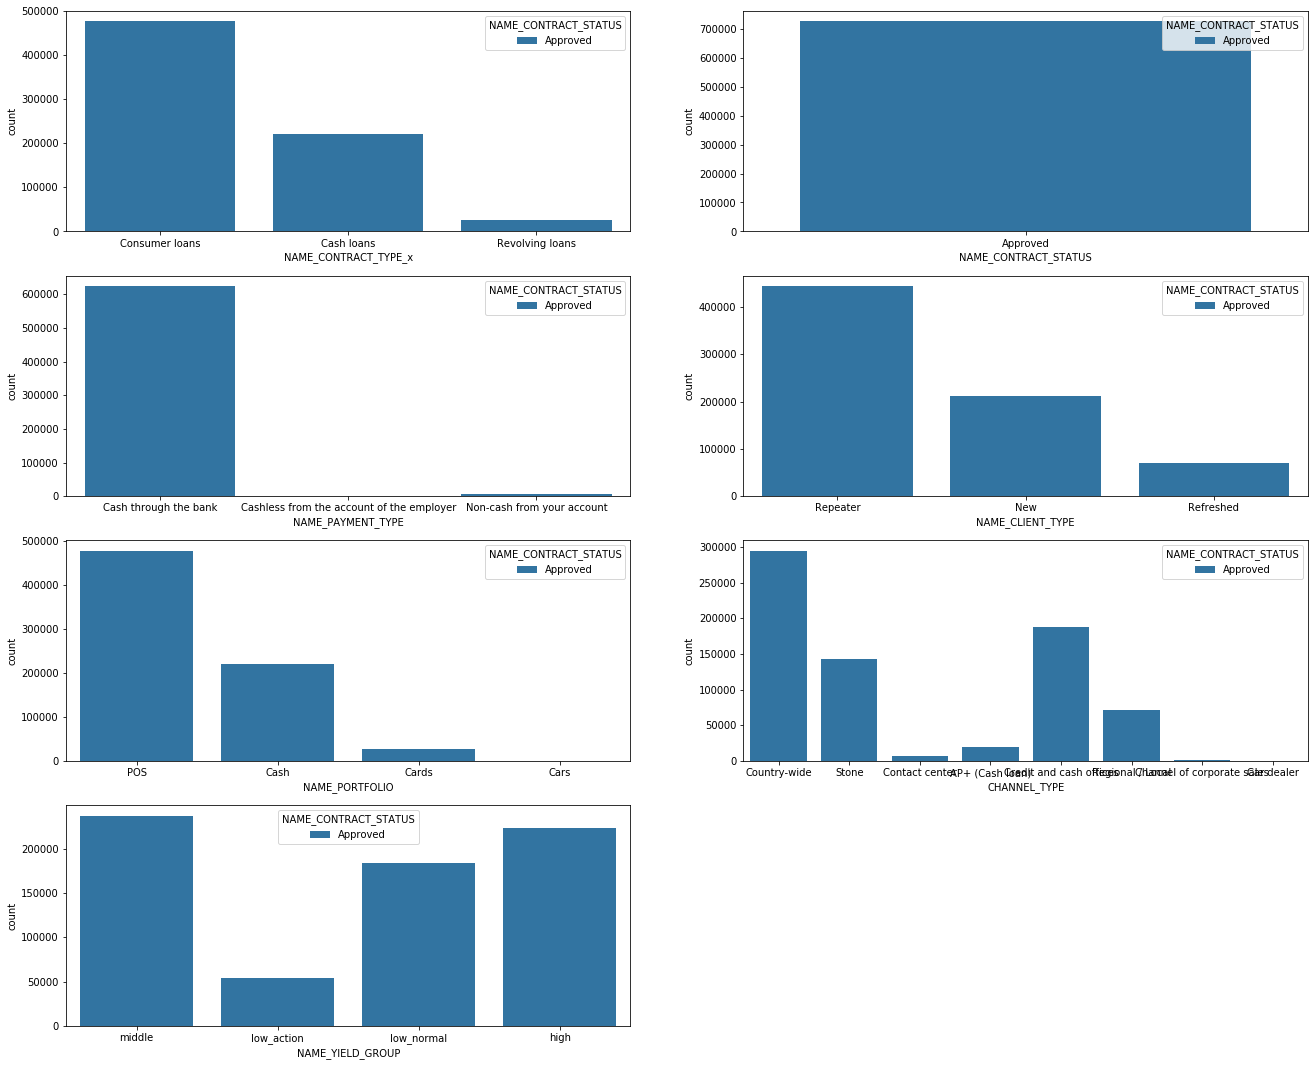

In [91]:
counter = 1
for i in ds_comb_with_non_def_obj.columns[0:7]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_non_def_obj[i].dropna(),data=ds_comb_with_non_def_obj) 
    #plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=.4, right=3, top=2.75)
    #plt.title(i)
    counter += 1

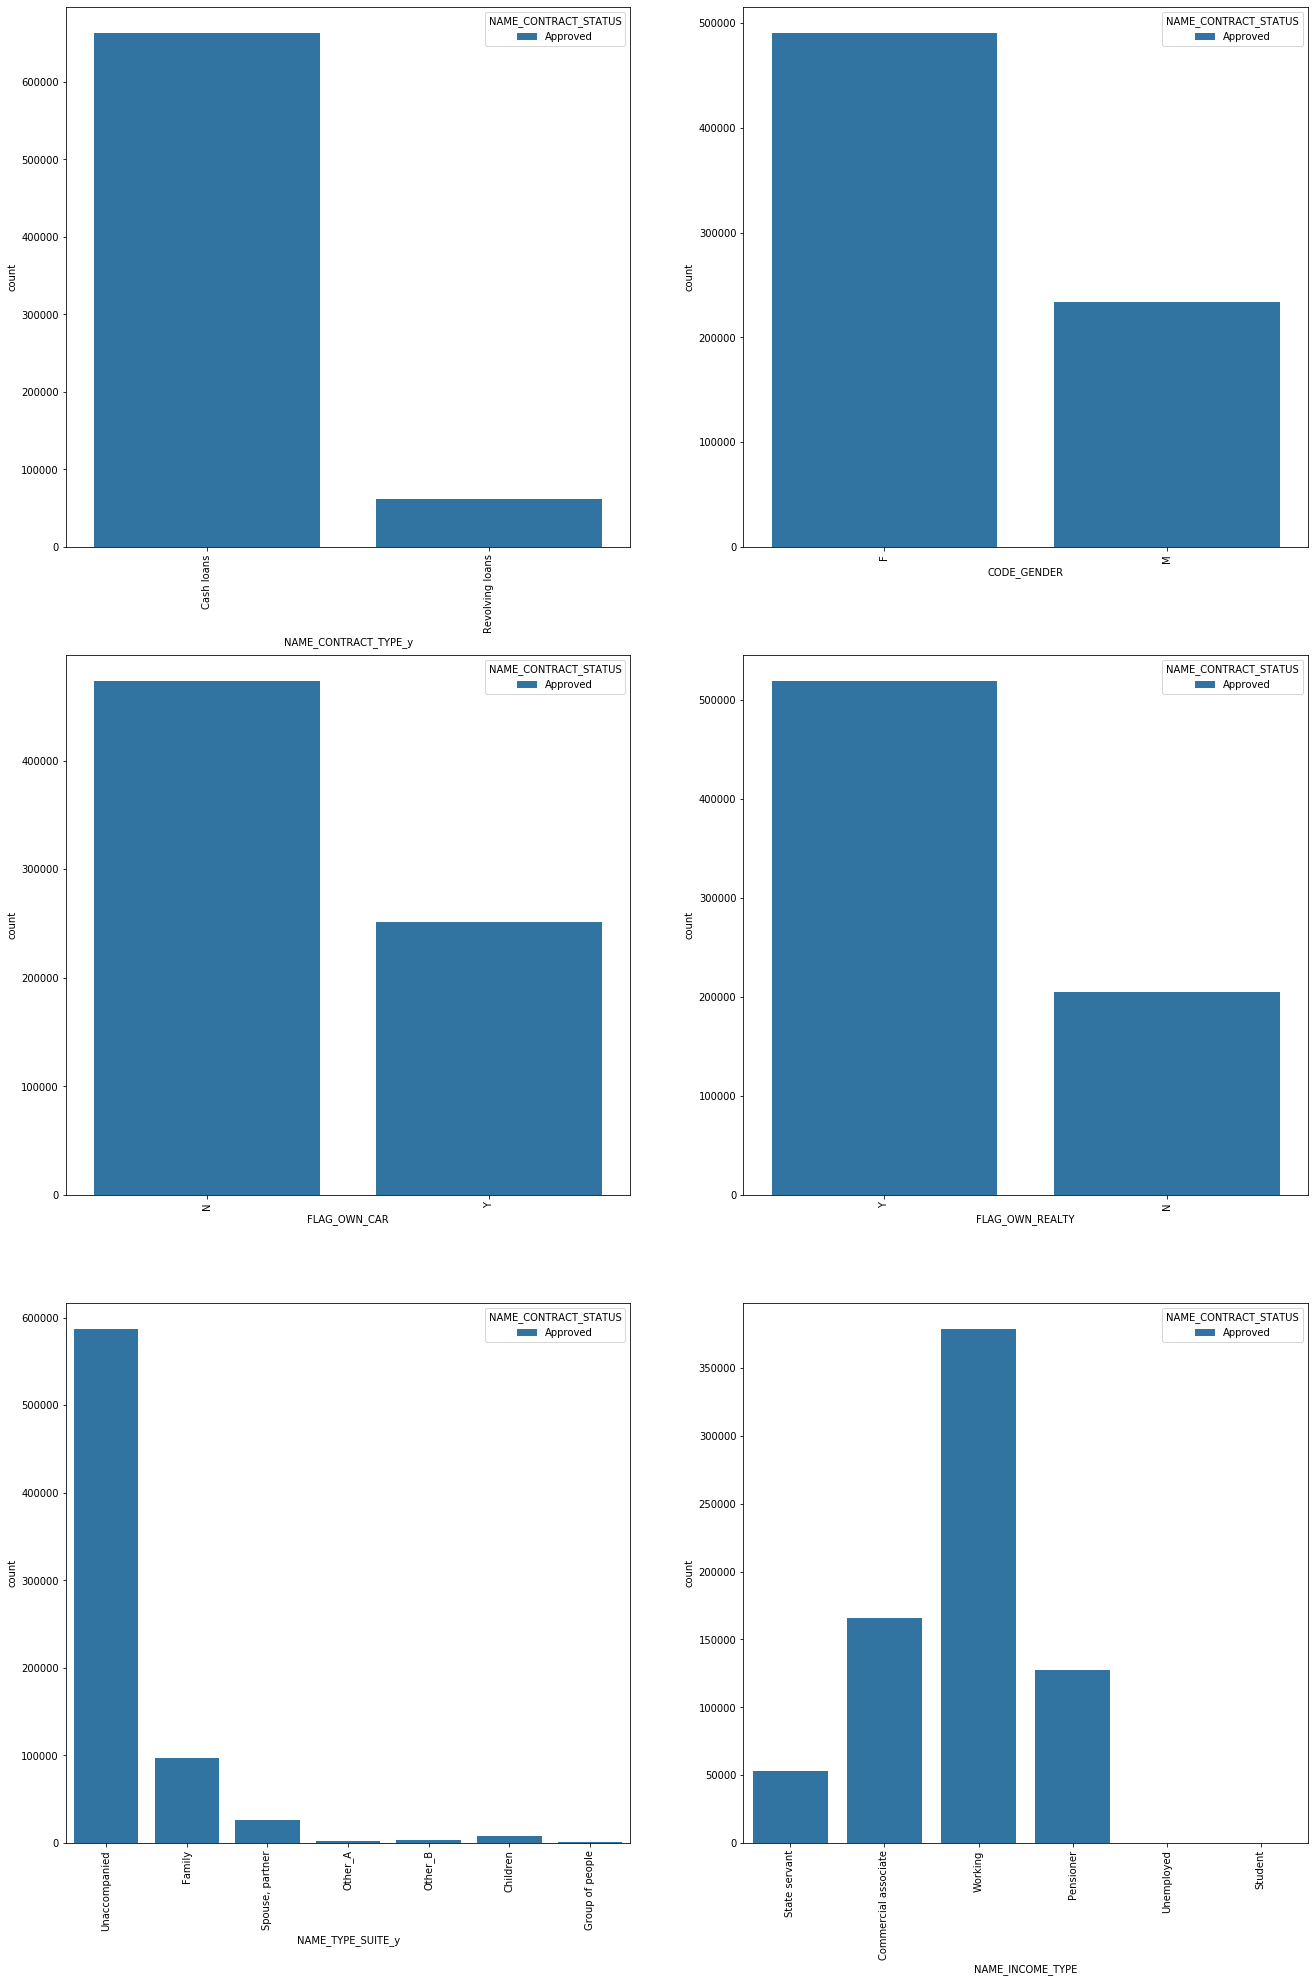

In [92]:
counter = 1
for i in ds_comb_with_non_def_obj.columns[8:14]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_non_def_obj[i].dropna(),data=ds_comb_with_non_def_obj) 
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=-3, right=3, top=2.75)
    #plt.title(i)
    #plt.show()
    counter += 1
    


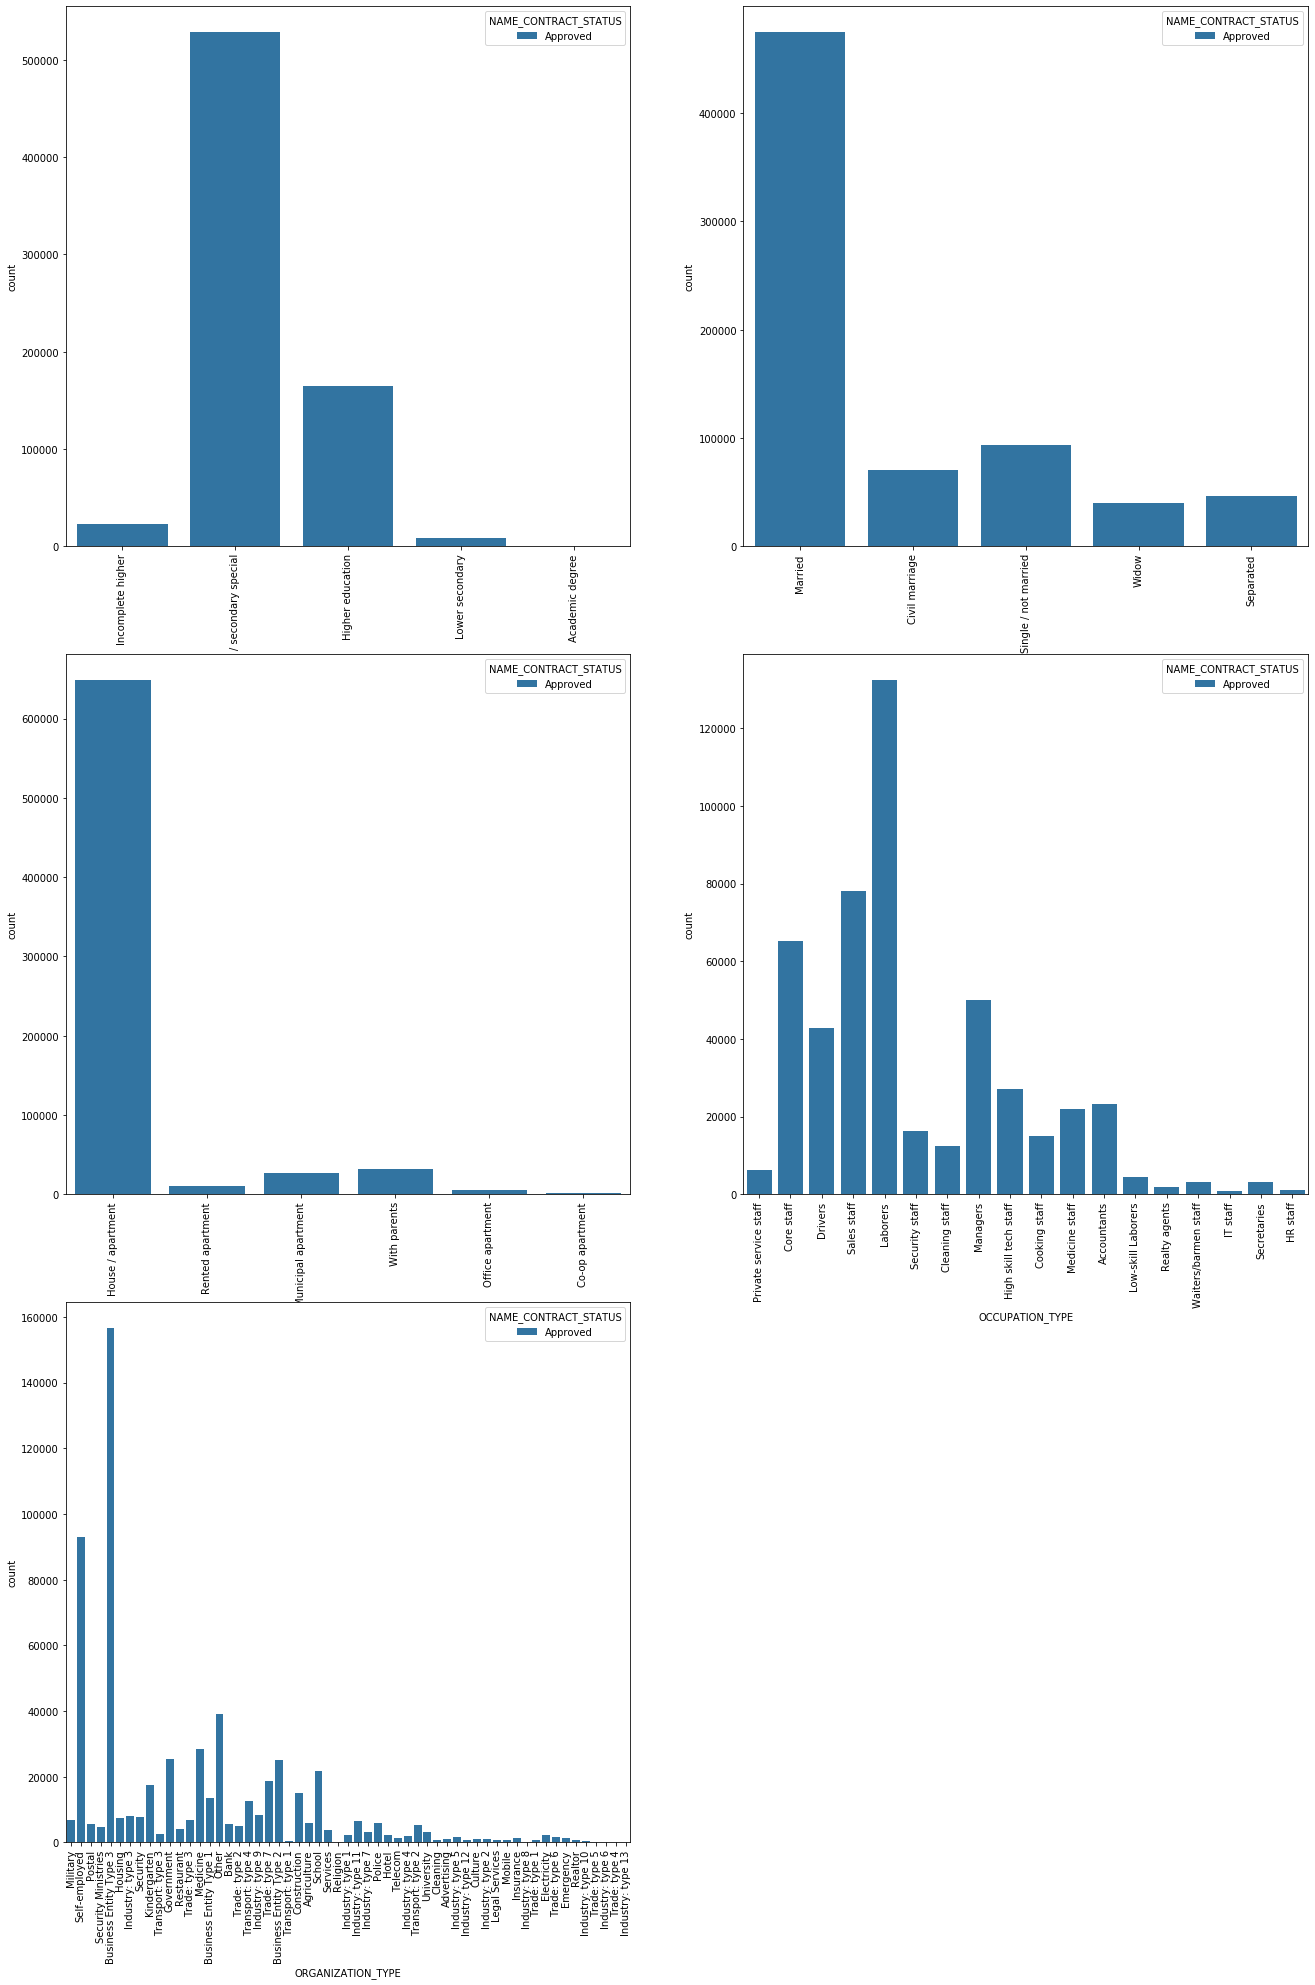

In [93]:
counter = 1
for i in ds_comb_with_non_def_obj.columns[14:]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_non_def_obj[i].dropna(),data=ds_comb_with_non_def_obj) 
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=-3, right=3, top=2.75)
    #plt.show()
    #plt.title(i)
    counter += 1

### Object Type columns for combined df with defaulter

In [94]:
ds_comb_with_def_obj = ds_comb_with_def.loc[:,ds_comb_with_def.dtypes==np.object]

In [101]:
ds_comb_with_def_obj.shape

(75864, 18)

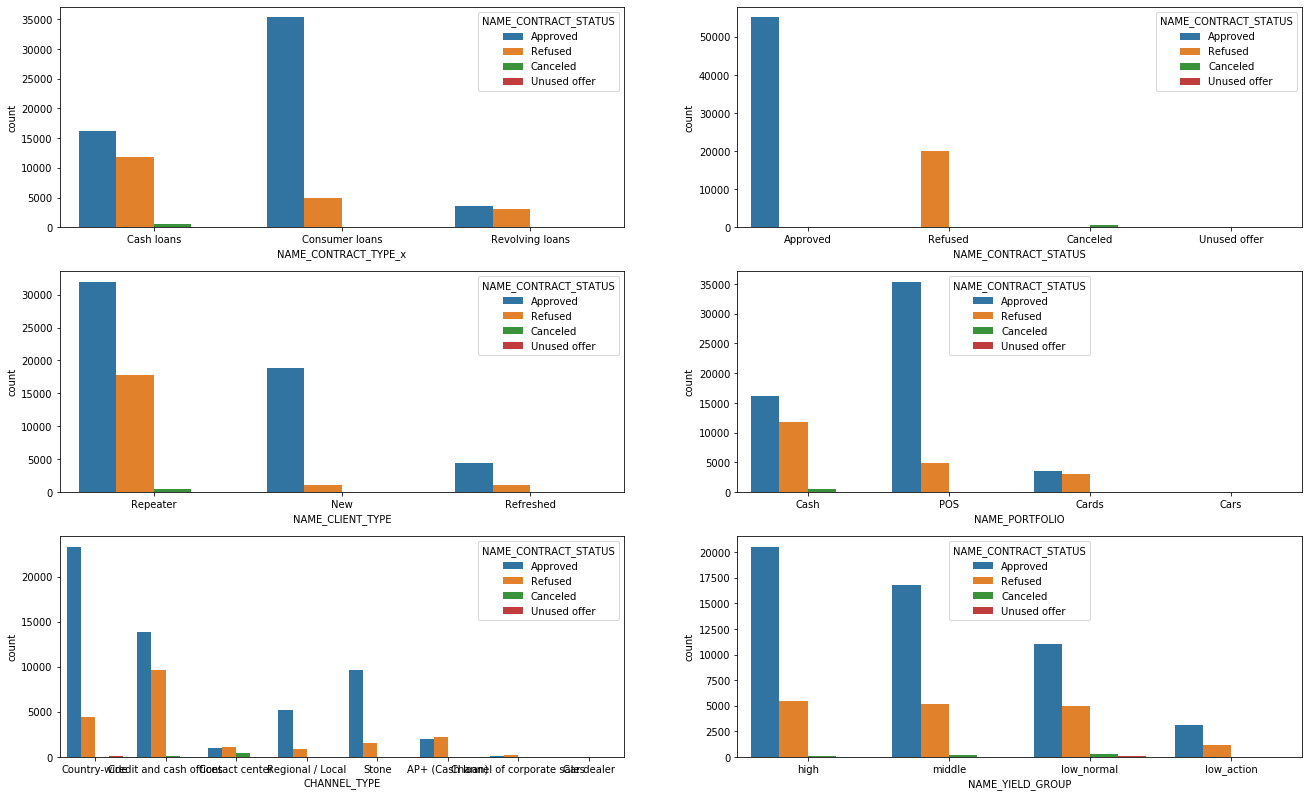

In [97]:
counter = 1
for i in ds_comb_with_def_obj.columns[0:6]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_def_obj[i].dropna(),data=ds_comb_with_def_obj) 
    #plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=.4, right=3, top=2.75)
    #plt.title(i)
    counter += 1

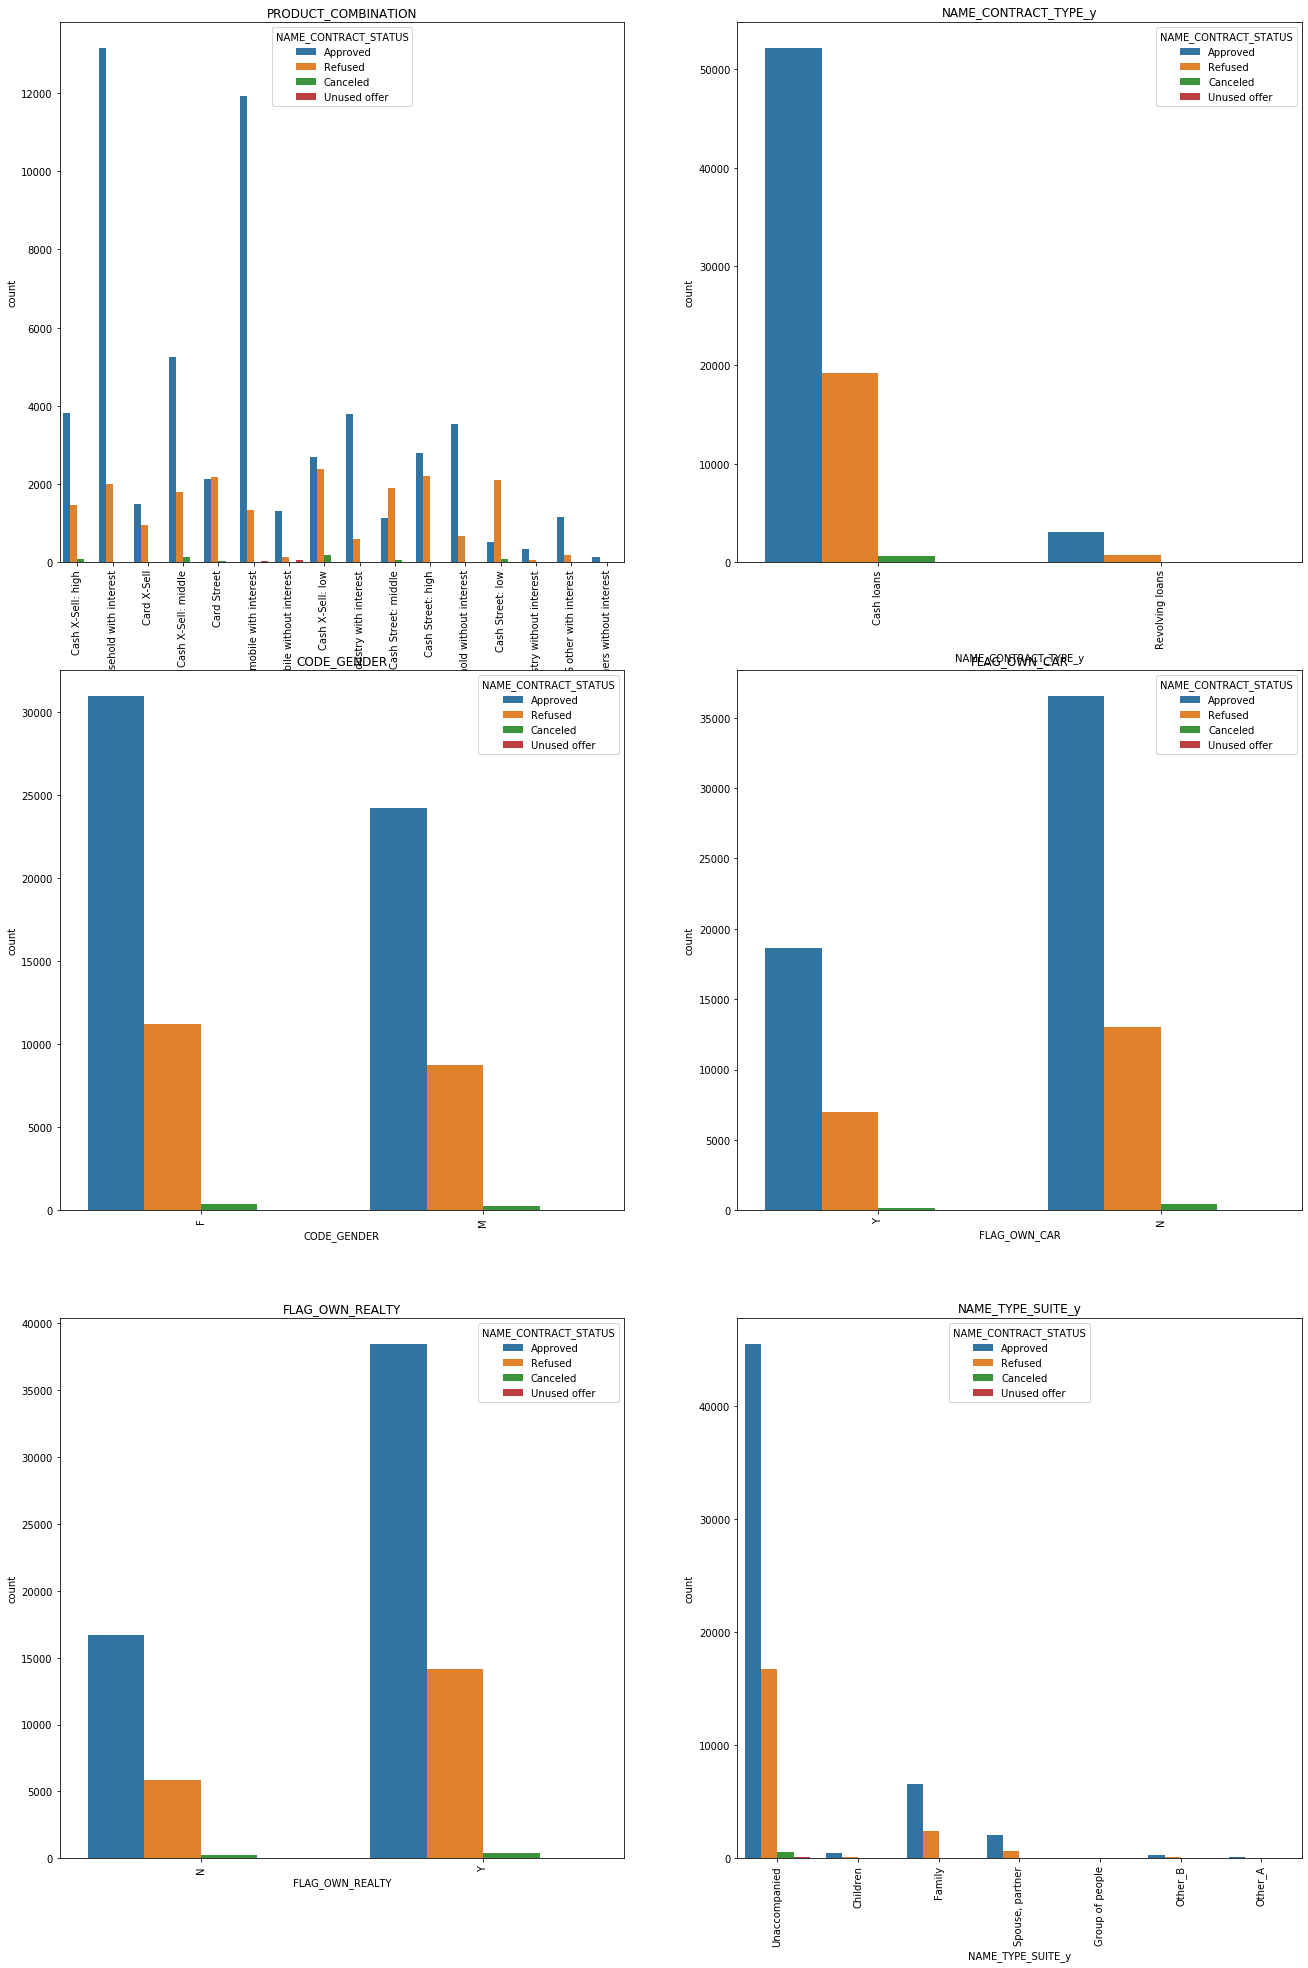

In [98]:
counter = 1
for i in ds_comb_with_def_obj.columns[6:12]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_def_obj[i].dropna(),data=ds_comb_with_def_obj) 
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=-3, right=3, top=2.75)
    plt.title(i)
    counter += 1

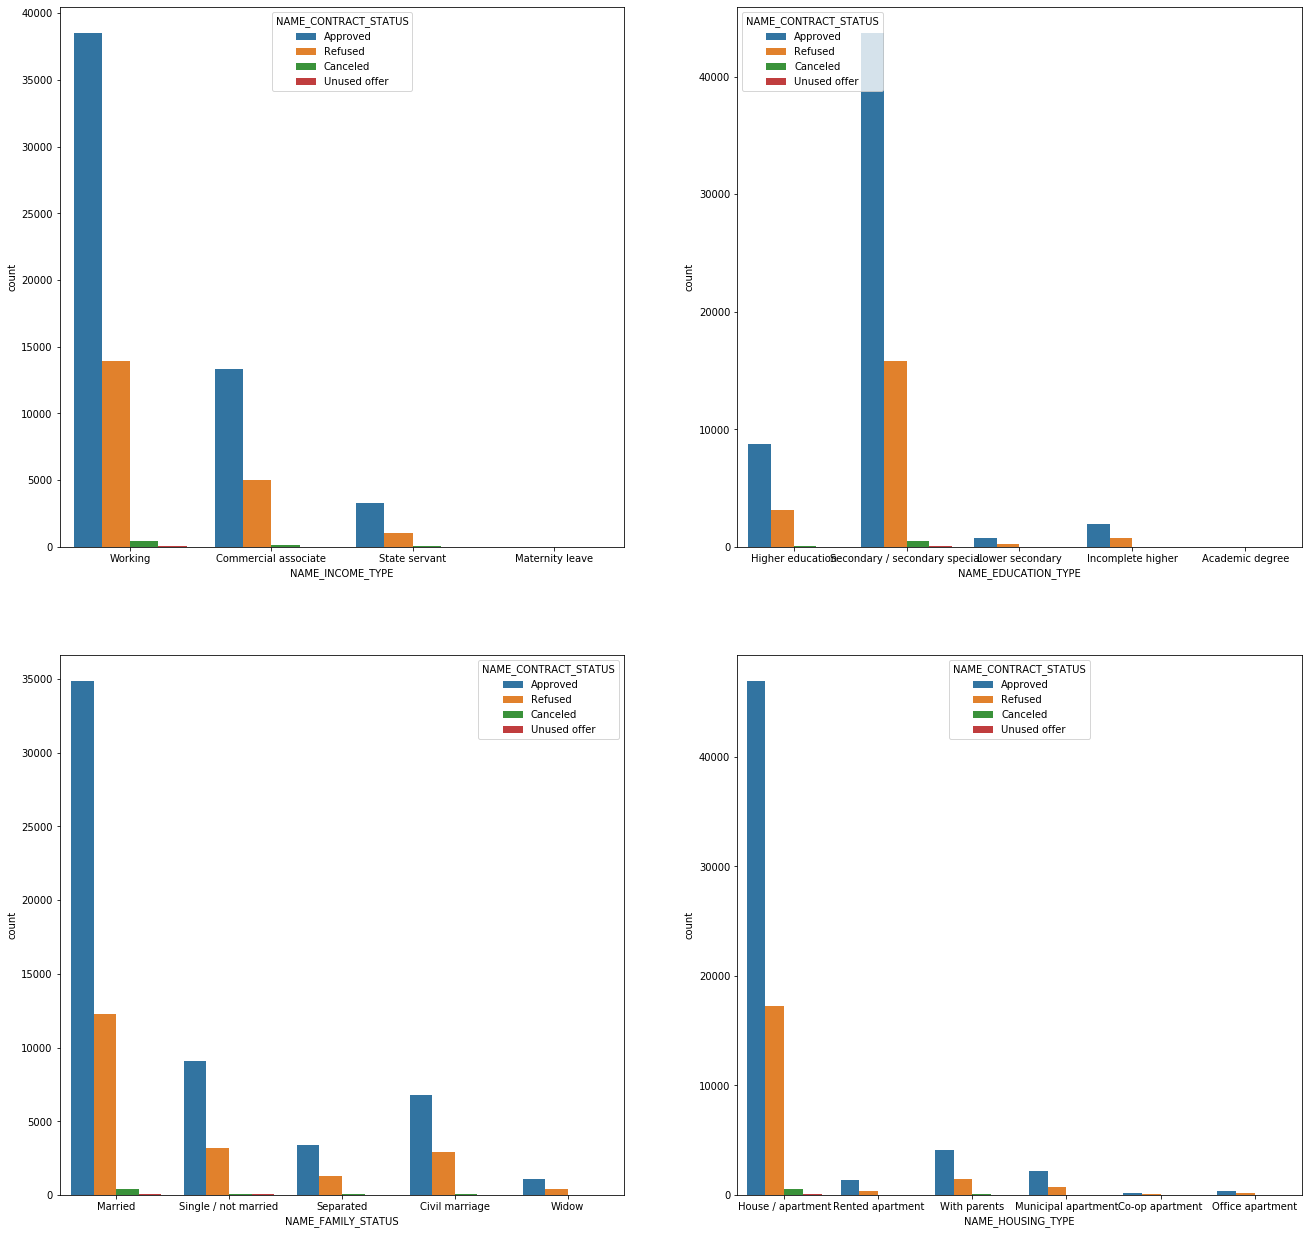

In [104]:
counter = 1
for i in ds_comb_with_def_obj.columns[12:16]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_def_obj[i].dropna(),data=ds_comb_with_def_obj) 
    #plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=-3, right=3, top=2.75)
    #plt.title(i)
    counter += 1

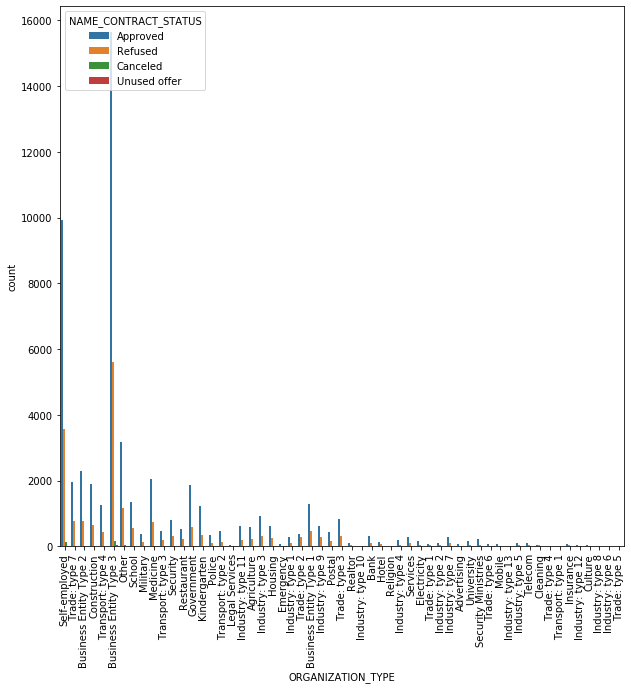

In [106]:
counter = 1
for i in ds_comb_with_def_obj.columns[17:18]:
    plt.subplot(4,2,counter)
    plt.rcParams["figure.figsize"] = [6,6]
    ax=sns.countplot(hue="NAME_CONTRACT_STATUS",x=ds_comb_with_def_obj[i].dropna(),data=ds_comb_with_def_obj) 
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=-3, right=3, top=2.75)
    #plt.title(i)
    counter += 1

### Working on numeric continuos variables to find out correlation

### Creating separate int and float dataframes from merged-defaulters and merged-nondefaulters Dfs  and then concatenating them respectively

In [125]:
ds_comb_with_non_def_float = ds_comb_with_non_def.loc[:,ds_comb_with_non_def.dtypes==np.float64]
ds_comb_with_non_def_int   = ds_comb_with_non_def.loc[:,ds_comb_with_non_def.dtypes==np.int64]

ds_comb_with_def_float = ds_comb_with_def.loc[:,ds_comb_with_def.dtypes == np.float64]
ds_comb_with_def   = ds_comb_with_def.loc[:,ds_comb_with_def.dtypes == np.int64]

In [126]:
ds_comb_with_non_def_numerical = pd.concat([ds_comb_with_non_def_float,ds_comb_with_non_def_int],axis=1)
ds_comb_with_def_numerical= pd.concat([ds_comb_with_def_float,ds_comb_with_def],axis=1)

In [137]:
ds_comb_with_def_numerical.head()

,SK_ID_PREV,SK_ID_CURR,DAYS_DECISION,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,Document,Applicant_Contact,Address_Missmatch
0,1676258,433469,-1883,1,0,-14560,-595,-1721,1,4,8
1,2246417,433469,-2202,1,0,-14560,-595,-1721,1,4,8
2,1758558,433469,-721,1,0,-14560,-595,-1721,1,4,8
4,2171757,433469,-721,1,0,-14560,-595,-1721,1,4,8
5,1499867,433469,-926,1,0,-14560,-595,-1721,1,4,8


In [136]:
ds_comb_with_def_numerical.columns
#ds_comb_with_non_def_numerical.shape

Index(['SK_ID_PREV', 'SK_ID_CURR', 'DAYS_DECISION', 'TARGET', 'CNT_CHILDREN',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'Document',
       'Applicant_Contact', 'Address_Missmatch'],
      dtype='object')

### Filtering out important Columns and creating a refined Dataframe for both merged-defaulters and merged-nondefaulters Dfs 

In [129]:
ds_comb_with_non_def_numerical_refined = ds_comb_with_non_def_numerical.filter(['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT',
'CNT_FAM_MEMBERS','Social_Circle_PD','Debt_Income_Ratio','CNT_CHILDREN','DAYS_EMPLOYED','DAYS_ID_PUBLISH','DAYS_BIRTH'])

In [140]:
ds_comb_with_def_numerical_refined = ds_comb_with_def_numerical.filter(['AMT_ANNUITY','AMT_APPLICATION','Address_Missmatch',
'CNT_FAM_MEMBERS','Applicant_Contact','DAYS_DECISION','CNT_CHILDREN','DAYS_EMPLOYED','DAYS_ID_PUBLISH','DAYS_BIRTH'])

In [141]:
ds_comb_with_def_numerical_refined.shape

(75864, 7)

## Removing Outliers

In [131]:
for i in ds_comb_with_non_def_numerical_refined.columns:
    q1 = ds_comb_with_non_def_numerical_refined[i].quantile(0.25)
    q3 = ds_comb_with_non_def_numerical_refined[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    l = q1-1.5*iqr
    h = q3+1.5*iqr
    ds_comb_with_non_def_numerical_refined = ds_comb_with_non_def_numerical_refined.loc[(ds_comb_with_non_def_numerical_refined[i] > l) & (ds_comb_with_non_def_numerical_refined[i] < h)]

In [142]:
for i in ds_comb_with_def_numerical_refined.columns:
    q1 = ds_comb_with_def_numerical_refined[i].quantile(0.25)
    q3 = ds_comb_with_def_numerical_refined[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    l = q1-1.5*iqr
    h = q3+1.5*iqr
    ds_comb_with_def_numerical_refined = ds_comb_with_def_numerical_refined.loc[(ds_comb_with_def_numerical_refined[i] > l) & (ds_comb_with_def_numerical_refined[i] < h)]

In [132]:
ds_comb_with_non_def_numerical_refined.shape

(393694, 10)

In [143]:
ds_comb_with_def_numerical_refined.shape

(68597, 7)

## Creating Heatmaps

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,CNT_FAM_MEMBERS,Social_Circle_PD,Debt_Income_Ratio,CNT_CHILDREN,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_BIRTH
AMT_ANNUITY,1.000000,0.957092,0.953653,-0.401218,-0.265665,-0.203187,-0.415953,-0.318419,-0.174016,-0.505406
AMT_APPLICATION,0.957092,1.000000,0.999468,-0.403134,-0.255892,-0.211285,-0.419614,-0.318053,-0.172517,-0.525390
AMT_CREDIT,0.953653,0.999468,1.000000,-0.404779,-0.253942,-0.212311,-0.421144,-0.315387,-0.171025,-0.525136
CNT_FAM_MEMBERS,-0.401218,-0.403134,-0.404779,1.000000,-0.101250,-0.064845,0.987417,-0.223046,-0.427657,0.250732
Social_Circle_PD,-0.265665,-0.255892,-0.253942,-0.101250,1.000000,-0.090065,-0.100179,-0.125783,-0.106925,-0.079627
Debt_Income_Ratio,-0.203187,-0.211285,-0.212311,-0.064845,-0.090065,1.000000,-0.113146,-0.179646,-0.106049,-0.250527
CNT_CHILDREN,-0.415953,-0.419614,-0.421144,0.987417,-0.100179,-0.113146,1.000000,-0.179134,-0.430057,0.314363
DAYS_EMPLOYED,-0.318419,-0.318053,-0.315387,-0.223046,-0.125783,-0.179646,-0.179134,1.000000,0.121318,0.317051
DAYS_ID_PUBLISH,-0.174016,-0.172517,-0.171025,-0.427657,-0.106925,-0.106049,-0.430057,0.121318,1.000000,-0.004207
DAYS_BIRTH,-0.505406,-0.525390,-0.525136,0.250732,-0.079627,-0.250527,0.314363,0.317051,-0.004207,1.000000


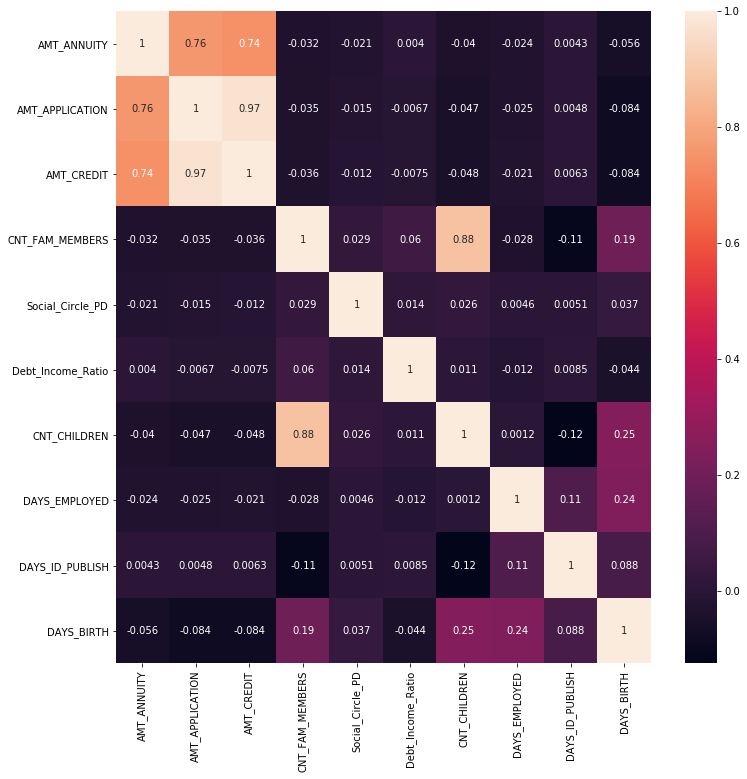

In [144]:
ds_comb_with_non_def_numerical_refined_corr = ds_comb_with_non_def_numerical_refined.corr()
plt.figure(figsize=(12,12))
ax=sns.heatmap(ds_comb_with_non_def_numerical_refined_corr,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ds_comb_with_non_def_numerical_refined_corr.corr()

,Address_Missmatch,Applicant_Contact,DAYS_DECISION,CNT_CHILDREN,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_BIRTH
Address_Missmatch,1.000000,1.000000,-0.332092,-0.303508,-0.428186,-0.345033,-0.341699
Applicant_Contact,1.000000,1.000000,-0.332092,-0.303508,-0.428186,-0.345033,-0.341699
DAYS_DECISION,-0.332092,-0.332092,1.000000,-0.251746,-0.026805,0.000453,-0.203781
CNT_CHILDREN,-0.303508,-0.303508,-0.251746,1.000000,-0.201298,-0.376971,0.182805
DAYS_EMPLOYED,-0.428186,-0.428186,-0.026805,-0.201298,1.000000,-0.020729,0.146020
DAYS_ID_PUBLISH,-0.345033,-0.345033,0.000453,-0.376971,-0.020729,1.000000,-0.059143
DAYS_BIRTH,-0.341699,-0.341699,-0.203781,0.182805,0.146020,-0.059143,1.000000


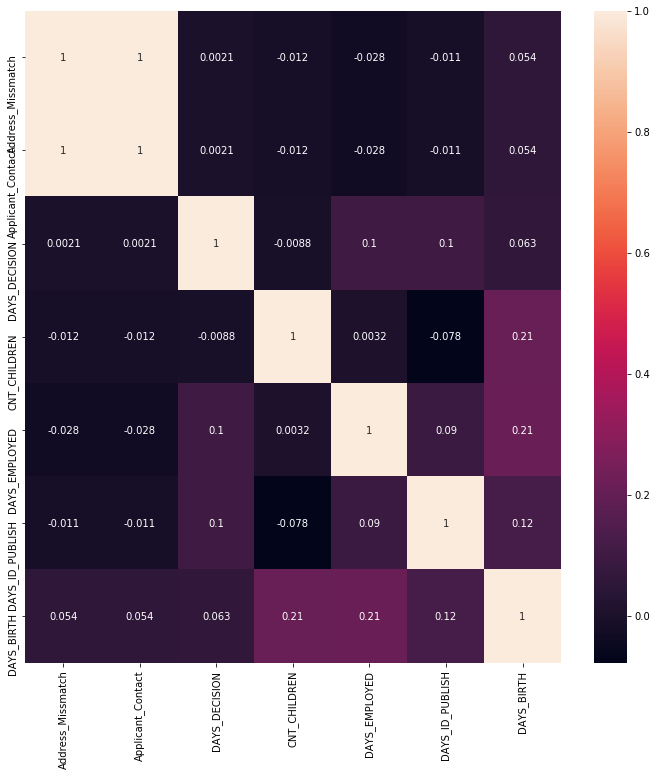

In [145]:
ds_comb_with_def_numerical_refined_corr = ds_comb_with_def_numerical_refined.corr()
plt.figure(figsize=(12,12))
ax=sns.heatmap(ds_comb_with_def_numerical_refined_corr,annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ds_comb_with_def_numerical_refined_corr.corr()